# Librerias

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm im
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

Using TensorFlow backend.


# Funciones

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    #dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata




def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128):
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')


# Cargar datos

## Generar imagenes con 3 canales

In [3]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [4]:
channel_1 = np.load('/work/work_teamEXOPLANET/MTF_gabo/no_invertidos/MTF_u128_d128.npy')  
channel_2 = np.load('/work/work_teamEXOPLANET/MTF_gabo/invertidos/MTF_u128_d128.npy')  
channel_3 = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/MTF_time_u128_d128.npy')  

In [5]:
print(channel_1.shape)
print(channel_2.shape)
print(channel_3.shape)

(8054, 256, 256)
(8054, 256, 256)
(8054, 256, 256)


###### 3 canales

In [6]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

###### 2 canales (sin tiempo)

In [7]:
'''x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)'''

'x_all = []\nfor i in range(channel_1.shape[0]):\n    combined_image = np.dstack((channel_1[i],channel_2[i]))\n    x_all.append(combined_image)\nx_all = np.asarray(x_all)'

###### 2 canales (marvko -> + tiempo)

In [6]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

###### 2 canales (arriba) + data augm

In [7]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

x_all2 = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_2[i],channel_3[i]))
    x_all2.append(combined_image)
x_all2 = np.asarray(x_all2)

In [8]:
x_all.shape

(8054, 256, 256, 2)

## Generar conjunto de entrenamiento y validación

In [9]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [10]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [12]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [13]:
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 256, 256, 2) (4339,)
Objetos de validación: (1918, 256, 256, 2) (1918,)


###### 2 canales (arriba) + data augm

In [14]:
x_train1 = x_all[mask_train]
x_train2 = x_all2[mask_train]
x_train = np.concatenate([x_train1,x_train2]) #concat

x_val = x_all[mask_test]

if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (8678, 256, 256, 2) (8678,)
Objetos de validación: (1918, 256, 256, 2) (1918,)


## Pruebas CNN utilizando loss = binary_crossentropy

In [45]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

Train on 8678 samples, validate on 1918 samples
Epoch 1/25
8678/8678 [==============================] - 2s 193us/step - loss: 0.6832 - acc: 0.6346 - val_loss: 4.3037 - val_acc: 0.3655
Epoch 2/25
8678/8678 [==============================] - 0s 56us/step - loss: 0.5573 - acc: 0.6790 - val_loss: 6.3304 - val_acc: 0.3514
Epoch 3/25
8678/8678 [==============================] - 0s 54us/step - loss: 0.5382 - acc: 0.7006 - val_loss: 0.9028 - val_acc: 0.5777
Epoch 4/25
8678/8678 [==============================] - 0s 53us/step - loss: 0.5233 - acc: 0.7027 - val_loss: 0.6805 - val_acc: 0.6361
Epoch 5/25
8678/8678 [==============================] - 0s 53us/step - loss: 0.5160 - acc: 0.7106 - val_loss: 1.9133 - val_acc: 0.4343
Epoch 6/25
8678/8678 [==============================] - 0s 54us/step - loss: 0.5070 - acc: 0.7184 - val_loss: 0.6899 - val_acc: 0.6204
Epoch 7/25
8678/8678 [==============================] - 0s 53us/step - loss: 0.5012 - acc: 0.7140 - val_loss: 1.1621 - val_acc: 0.5787
Epoch 

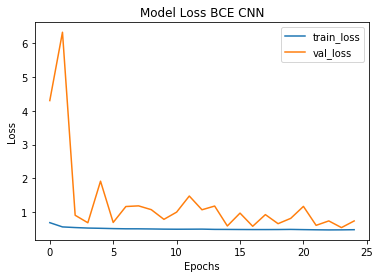

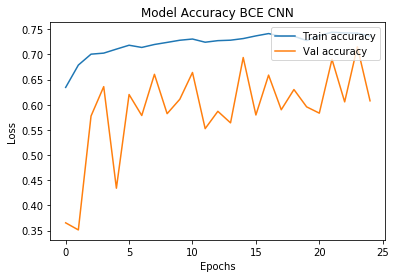

In [17]:
hist=model.fit(x_train, y_train, batch_size=128, epochs=25, verbose=1, validation_data=(x_val,y_val))

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

### Experimentos FMEna - f1 score

In [15]:
import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

## Modificaciones
* guarda el mejor modelo (pesos) en base a val loss random (10%)

In [47]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      608       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 123008)           

In [48]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

Train on 7810 samples, validate on 868 samples
Epoch 1/200
 768/7810 [=>............................] - ETA: 2:44 - loss: 0.8548 - accuracy: 0.5684

TypeError: 'NoneType' object is not subscriptable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.826427,0.847634,0.836896,0.78393,0.761196,0.785193
Confirmed,0.702660,0.669151,0.685496,0.78393,0.761196,0.785193


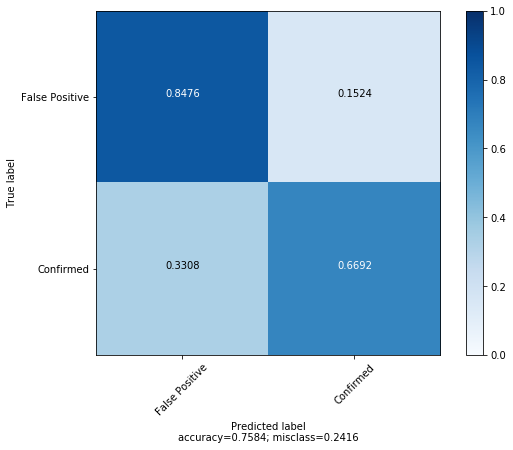

{'Precision raw': array([0.8264269 , 0.70266041]),
 'Recall raw': array([0.84763432, 0.66915052]),
 'F1 raw': array([0.83689628, 0.68549618]),
 'F1 weighted': 0.7839299262106746,
 'F1 macro': 0.7611962309538056,
 'F1 micro': 0.7851929092805006,
 'Confusion Matrix': array([[1057,  190],
        [ 222,  449]])}

In [21]:
model = keras.models.load_model("best_mod.hdf5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 4s 464us/step - loss: 0.4027 - acc: 0.7817 - val_loss: 0.4449 - val_acc: 0.7373
Epoch 2/200
7810/7810 [==============================] - 2s 259us/step - loss: 0.4013 - acc: 0.7803 - val_loss: 0.4368 - val_acc: 0.7615
Epoch 3/200
7810/7810 [==============================] - 2s 255us/step - loss: 0.3979 - acc: 0.7834 - val_loss: 0.4427 - val_acc: 0.7442
Epoch 4/200
7810/7810 [==============================] - 2s 256us/step - loss: 0.3994 - acc: 0.7843 - val_loss: 0.4498 - val_acc: 0.7339
Epoch 5/200
7810/7810 [==============================] - 2s 251us/step - loss: 0.3994 - acc: 0.7822 - val_loss: 0.4400 - val_acc: 0.7408
Epoch 6/200
7810/7810 [==============================] - 2s 238us/step - loss: 0.4002 - acc: 0.7868 - val_loss: 0.4329 - val_acc: 0.7488
Epoch 7/200
7810/7810 [==============================] - 2s 238us/step - loss: 0.4000 - acc: 0.7834 - val_loss: 0.4420 - val_acc: 0

Epoch 35/200
7810/7810 [==============================] - 2s 235us/step - loss: 0.3894 - acc: 0.7927 - val_loss: 0.4366 - val_acc: 0.7396
Epoch 36/200
7810/7810 [==============================] - 2s 231us/step - loss: 0.3969 - acc: 0.7818 - val_loss: 0.4377 - val_acc: 0.7442
Epoch 37/200
7810/7810 [==============================] - 2s 234us/step - loss: 0.3881 - acc: 0.7889 - val_loss: 0.4382 - val_acc: 0.7304
Epoch 38/200
7810/7810 [==============================] - 2s 231us/step - loss: 0.3857 - acc: 0.7948 - val_loss: 0.4370 - val_acc: 0.7431
Epoch 39/200
7810/7810 [==============================] - 2s 235us/step - loss: 0.3862 - acc: 0.7933 - val_loss: 0.4298 - val_acc: 0.7627
Epoch 40/200
7810/7810 [==============================] - 2s 235us/step - loss: 0.3899 - acc: 0.7928 - val_loss: 0.4348 - val_acc: 0.7419
Epoch 41/200
7810/7810 [==============================] - 2s 231us/step - loss: 0.3863 - acc: 0.7942 - val_loss: 0.4381 - val_acc: 0.7465
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 2s 231us/step - loss: 0.3708 - acc: 0.8031 - val_loss: 0.4402 - val_acc: 0.7488
Epoch 104/200
7810/7810 [==============================] - 2s 239us/step - loss: 0.3686 - acc: 0.8047 - val_loss: 0.4193 - val_acc: 0.7788
Epoch 105/200
7810/7810 [==============================] - 2s 234us/step - loss: 0.3672 - acc: 0.8059 - val_loss: 0.4407 - val_acc: 0.7408
Epoch 106/200
7810/7810 [==============================] - 2s 238us/step - loss: 0.3798 - acc: 0.7991 - val_loss: 0.4277 - val_acc: 0.7673
Epoch 107/200
7810/7810 [==============================] - 2s 231us/step - loss: 0.3709 - acc: 0.8060 - val_loss: 0.4367 - val_acc: 0.7408
Epoch 108/200
7810/7810 [==============================] - 2s 231us/step - loss: 0.3682 - acc: 0.8024 - val_loss: 0.4354 - val_acc: 0.7465
Epoch 109/200
7810/7810 [==============================] - 2s 231us/step - loss: 0.3718 - acc: 0.8022 - val_loss: 0.4245 - val_acc: 0.7581
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 2s 230us/step - loss: 0.3574 - acc: 0.8137 - val_loss: 0.4343 - val_acc: 0.7535
Epoch 138/200
7810/7810 [==============================] - 2s 233us/step - loss: 0.3600 - acc: 0.8100 - val_loss: 0.4308 - val_acc: 0.7488
Epoch 139/200
7810/7810 [==============================] - 2s 229us/step - loss: 0.3567 - acc: 0.8118 - val_loss: 0.4307 - val_acc: 0.7523
Epoch 140/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3567 - acc: 0.8159 - val_loss: 0.4342 - val_acc: 0.7523
Epoch 141/200
7810/7810 [==============================] - 2s 235us/step - loss: 0.3600 - acc: 0.8106 - val_loss: 0.4349 - val_acc: 0.7512
Epoch 142/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3617 - acc: 0.8129 - val_loss: 0.4319 - val_acc: 0.7488
Epoch 143/200
7810/7810 [==============================] - 2s 252us/step - loss: 0.3614 - acc: 0.8088 - val_loss: 0.4184 - val_acc: 0.7661
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 2s 230us/step - loss: 0.3459 - acc: 0.8229 - val_loss: 0.4339 - val_acc: 0.7638
Epoch 172/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3479 - acc: 0.8201 - val_loss: 0.4204 - val_acc: 0.7592
Epoch 173/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3499 - acc: 0.8169 - val_loss: 0.4232 - val_acc: 0.7719
Epoch 174/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3502 - acc: 0.8143 - val_loss: 0.4279 - val_acc: 0.7523
Epoch 175/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3491 - acc: 0.8187 - val_loss: 0.4345 - val_acc: 0.7535
Epoch 176/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3523 - acc: 0.8220 - val_loss: 0.4304 - val_acc: 0.7362
Epoch 177/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3548 - acc: 0.8169 - val_loss: 0.4331 - val_acc: 0.7419
Epoch 178/200
7810/7810 [================

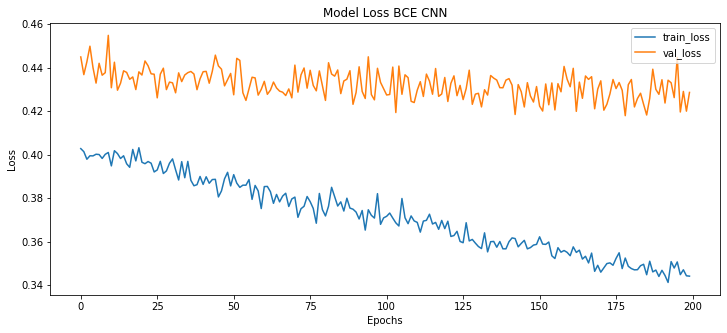

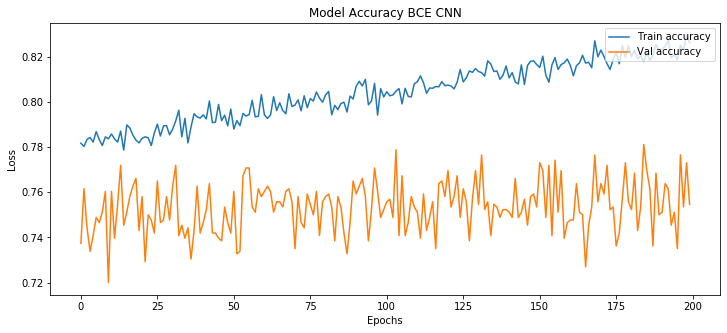

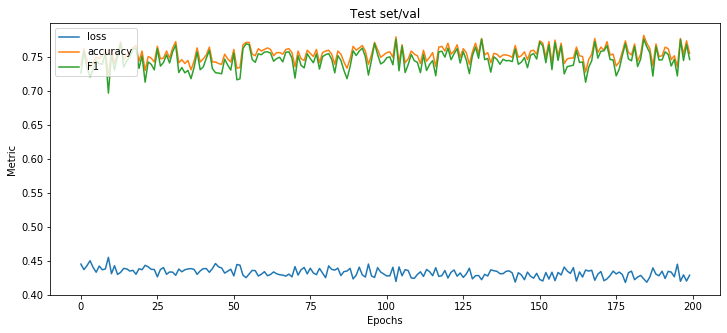

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.824141,0.826784,0.825460,0.772522,0.7498,0.77268
Confirmed,0.676162,0.672131,0.674141,0.772522,0.7498,0.77268


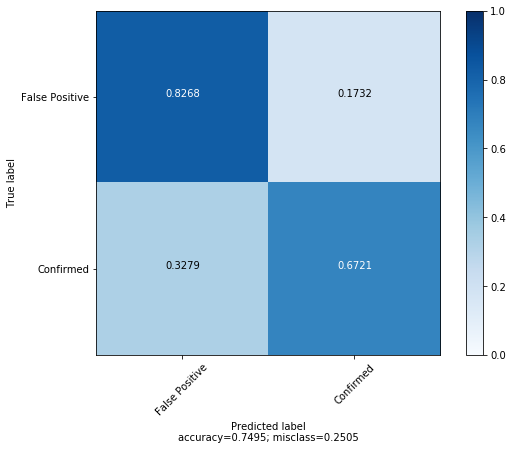

{'Precision raw': array([0.82414069, 0.67616192]),
 'Recall raw': array([0.82678428, 0.67213115]),
 'F1 raw': array([0.82546037, 0.67414051]),
 'F1 weighted': 0.7725220856516439,
 'F1 macro': 0.7498004382579306,
 'F1 micro': 0.7726798748696558,
 'Confusion Matrix': array([[1031,  216],
        [ 220,  451]])}

In [22]:
#con reduce lr #0.2 y lr 0.001 (pat 10)
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, save_f='best_mod2.hdf5') 
model = keras.models.load_model("best_mod2.hdf5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
__________

## focal loss
> sin lr decay

In [16]:
keras.losses.binary_focal_loss_fixed = keras.losses.mse

In [ ]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 4s 546us/step - loss: 13.0093 - acc: 0.7670 - val_loss: 12.7522 - val_acc: 0.7558
Epoch 2/200
7810/7810 [==============================] - 2s 250us/step - loss: 13.1887 - acc: 0.7671 - val_loss: 12.9162 - val_acc: 0.7650
Epoch 3/200
7810/7810 [==============================] - 2s 237us/step - loss: 13.0613 - acc: 0.7698 - val_loss: 13.0082 - val_acc: 0.7465
Epoch 4/200
7810/7810 [==============================] - 2s 240us/step - loss: 12.9669 - acc: 0.7720 - val_loss: 12.8316 - val_acc: 0.7661
Epoch 5/200
7810/7810 [==============================] - 2s 258us/step - loss: 12.8835 - acc: 0.7700 - val_loss: 12.8250 - val_acc: 0.7650
Epoch 6/200
7810/7810 [==============================] - 2s 246us/step - loss: 12.9475 - acc: 0.7685 - val_loss: 12.7124 - val_acc: 0.7661
Epoch 7/200
7810/7810 [==============================] - 2s 239us/step - loss: 12.6837 - acc: 0.7795 - val_loss: 13.069

Epoch 35/200
7810/7810 [==============================] - 2s 243us/step - loss: 12.7583 - acc: 0.7717 - val_loss: 12.7554 - val_acc: 0.7707
Epoch 36/200
7810/7810 [==============================] - 2s 244us/step - loss: 12.7168 - acc: 0.7789 - val_loss: 12.6105 - val_acc: 0.7638
Epoch 37/200
7810/7810 [==============================] - 2s 247us/step - loss: 12.7070 - acc: 0.7757 - val_loss: 12.5987 - val_acc: 0.7719
Epoch 38/200
7810/7810 [==============================] - 2s 236us/step - loss: 12.7388 - acc: 0.7754 - val_loss: 12.7451 - val_acc: 0.7627
Epoch 39/200
7810/7810 [==============================] - 2s 246us/step - loss: 12.7565 - acc: 0.7752 - val_loss: 12.6224 - val_acc: 0.7696
Epoch 40/200
7810/7810 [==============================] - 2s 251us/step - loss: 12.6380 - acc: 0.7768 - val_loss: 12.4840 - val_acc: 0.7707
Epoch 41/200
7810/7810 [==============================] - 2s 244us/step - loss: 12.8177 - acc: 0.7741 - val_loss: 12.6989 - val_acc: 0.7707
Epoch 42/200
7810/78

Epoch 69/200
7810/7810 [==============================] - 2s 251us/step - loss: 12.2322 - acc: 0.7894 - val_loss: 12.4065 - val_acc: 0.7730
Epoch 70/200
7810/7810 [==============================] - 2s 241us/step - loss: 12.3860 - acc: 0.7858 - val_loss: 12.4718 - val_acc: 0.7823
Epoch 71/200
7810/7810 [==============================] - 2s 237us/step - loss: 12.1206 - acc: 0.7908 - val_loss: 12.3841 - val_acc: 0.7776
Epoch 72/200
7810/7810 [==============================] - 2s 240us/step - loss: 12.3199 - acc: 0.7881 - val_loss: 12.6330 - val_acc: 0.7869
Epoch 73/200
7810/7810 [==============================] - 2s 237us/step - loss: 12.2186 - acc: 0.7863 - val_loss: 12.3915 - val_acc: 0.7742
Epoch 74/200
7810/7810 [==============================] - 2s 239us/step - loss: 12.5098 - acc: 0.7800 - val_loss: 12.5229 - val_acc: 0.7673
Epoch 75/200
7810/7810 [==============================] - 2s 233us/step - loss: 12.1421 - acc: 0.7894 - val_loss: 12.5161 - val_acc: 0.7765
Epoch 76/200
7810/78

Epoch 103/200
7810/7810 [==============================] - 2s 237us/step - loss: 12.1625 - acc: 0.7933 - val_loss: 12.4014 - val_acc: 0.7742
Epoch 104/200
7810/7810 [==============================] - 2s 237us/step - loss: 12.1596 - acc: 0.7877 - val_loss: 12.3839 - val_acc: 0.7673
Epoch 105/200
7810/7810 [==============================] - 2s 251us/step - loss: 12.2503 - acc: 0.7900 - val_loss: 12.4718 - val_acc: 0.7834
Epoch 106/200
7810/7810 [==============================] - 2s 238us/step - loss: 11.8407 - acc: 0.7919 - val_loss: 12.2325 - val_acc: 0.7753
Epoch 107/200
7810/7810 [==============================] - 2s 240us/step - loss: 12.1988 - acc: 0.7946 - val_loss: 12.6916 - val_acc: 0.7615
Epoch 108/200
7810/7810 [==============================] - 2s 233us/step - loss: 11.9236 - acc: 0.7944 - val_loss: 12.4671 - val_acc: 0.7684
Epoch 109/200
7810/7810 [==============================] - 2s 233us/step - loss: 11.9007 - acc: 0.7981 - val_loss: 12.4407 - val_acc: 0.7707
Epoch 110/200

Epoch 137/200
7810/7810 [==============================] - 2s 242us/step - loss: 11.7113 - acc: 0.8063 - val_loss: 12.9087 - val_acc: 0.7419
Epoch 138/200
7810/7810 [==============================] - 2s 240us/step - loss: 11.6260 - acc: 0.7997 - val_loss: 12.7757 - val_acc: 0.7488
Epoch 139/200
7810/7810 [==============================] - 2s 240us/step - loss: 11.8759 - acc: 0.7977 - val_loss: 12.4193 - val_acc: 0.7742
Epoch 140/200
7810/7810 [==============================] - 2s 243us/step - loss: 11.9938 - acc: 0.7919 - val_loss: 12.1197 - val_acc: 0.7776
Epoch 141/200
7810/7810 [==============================] - 2s 234us/step - loss: 11.8559 - acc: 0.7958 - val_loss: 12.2893 - val_acc: 0.7742
Epoch 142/200
7810/7810 [==============================] - 2s 241us/step - loss: 11.8373 - acc: 0.7955 - val_loss: 12.5281 - val_acc: 0.7730
Epoch 143/200
7810/7810 [==============================] - 2s 236us/step - loss: 11.6734 - acc: 0.8012 - val_loss: 12.5522 - val_acc: 0.7569
Epoch 144/200

Epoch 171/200
7810/7810 [==============================] - 2s 237us/step - loss: 11.4143 - acc: 0.8064 - val_loss: 12.6487 - val_acc: 0.7673
Epoch 172/200
7810/7810 [==============================] - 2s 237us/step - loss: 11.6258 - acc: 0.8076 - val_loss: 12.5349 - val_acc: 0.7753
Epoch 173/200
7810/7810 [==============================] - 2s 235us/step - loss: 11.4849 - acc: 0.8104 - val_loss: 12.3032 - val_acc: 0.7719
Epoch 174/200
7810/7810 [==============================] - 2s 237us/step - loss: 11.5081 - acc: 0.8054 - val_loss: 12.4515 - val_acc: 0.7661
Epoch 175/200
7810/7810 [==============================] - 2s 237us/step - loss: 11.3766 - acc: 0.8072 - val_loss: 12.3972 - val_acc: 0.7684
Epoch 176/200
7810/7810 [==============================] - 2s 237us/step - loss: 11.3814 - acc: 0.8082 - val_loss: 12.1956 - val_acc: 0.7638
Epoch 177/200
7810/7810 [==============================] - 2s 233us/step - loss: 11.5141 - acc: 0.7976 - val_loss: 12.5599 - val_acc: 0.7684
Epoch 178/200

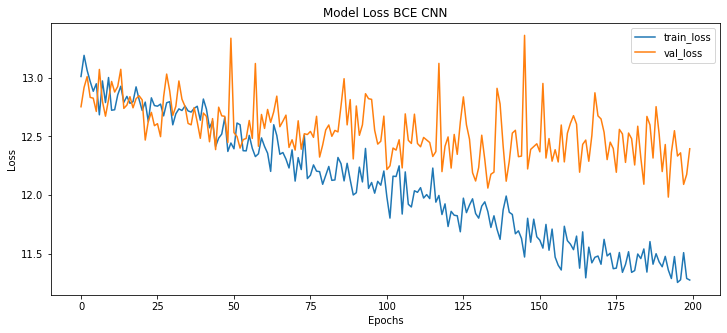

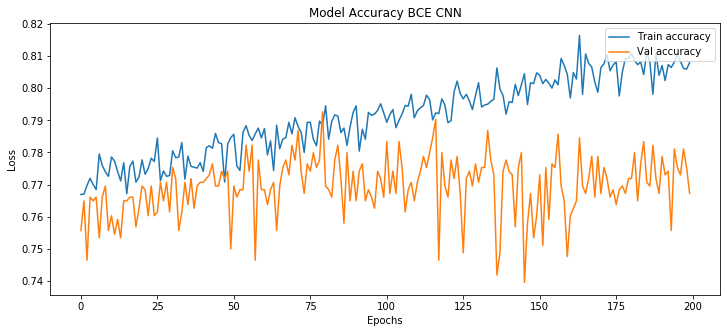

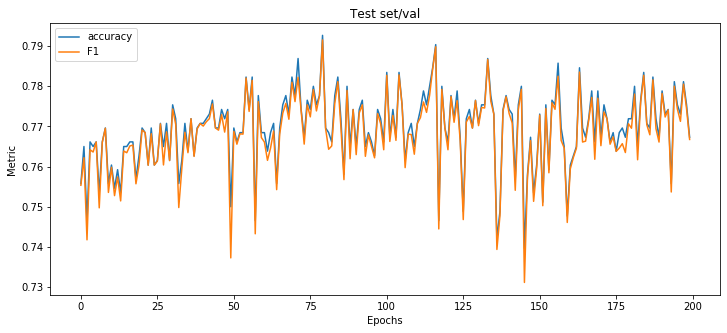

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.865116,0.745790,0.801034,0.763885,0.747941,0.759124
Confirmed,0.623962,0.783905,0.694848,0.763885,0.747941,0.759124


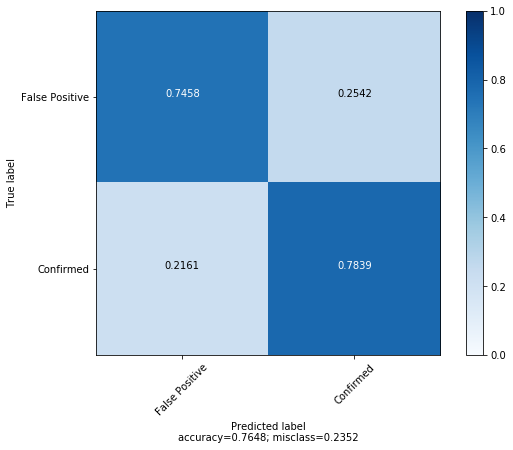

{'Precision raw': array([0.86511628, 0.62396204]),
 'Recall raw': array([0.7457899 , 0.78390462]),
 'F1 raw': array([0.80103359, 0.69484808]),
 'F1 weighted': 0.7638852730021288,
 'F1 macro': 0.7479408381377599,
 'F1 micro': 0.7591240875912408,
 'Confusion Matrix': array([[930, 317],
        [145, 526]])}

In [26]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.55)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 582us/step - loss: 11.1782 - acc: 0.8013 - val_loss: 12.1850 - val_acc: 0.7615
Epoch 2/200
7810/7810 [==============================] - 2s 259us/step - loss: 11.1524 - acc: 0.8051 - val_loss: 12.2338 - val_acc: 0.7650
Epoch 3/200
7810/7810 [==============================] - 2s 255us/step - loss: 11.2295 - acc: 0.8020 - val_loss: 12.0422 - val_acc: 0.7615
Epoch 4/200
7810/7810 [==============================] - 2s 250us/step - loss: 11.1803 - acc: 0.7972 - val_loss: 12.4255 - val_acc: 0.7627
Epoch 5/200
7810/7810 [==============================] - 2s 250us/step - loss: 11.0421 - acc: 0.8055 - val_loss: 12.1963 - val_acc: 0.7661
Epoch 6/200
7810/7810 [==============================] - 2s 235us/step - loss: 11.3161 - acc: 0.7954 - val_loss: 12.0872 - val_acc: 0.7776
Epoch 7/200
7810/7810 [==============================] - 2s 235us/step - loss: 11.1453 - acc: 0.8031 - val_loss: 12.002

Epoch 35/200
7810/7810 [==============================] - 2s 232us/step - loss: 11.0755 - acc: 0.8050 - val_loss: 11.8618 - val_acc: 0.7696
Epoch 36/200
7810/7810 [==============================] - 2s 232us/step - loss: 11.0446 - acc: 0.7973 - val_loss: 12.0302 - val_acc: 0.7592
Epoch 37/200
7810/7810 [==============================] - 2s 231us/step - loss: 10.8118 - acc: 0.8068 - val_loss: 12.2091 - val_acc: 0.7650
Epoch 38/200
7810/7810 [==============================] - 2s 232us/step - loss: 10.9611 - acc: 0.8005 - val_loss: 12.1339 - val_acc: 0.7673
Epoch 39/200
7810/7810 [==============================] - 2s 234us/step - loss: 10.7360 - acc: 0.8060 - val_loss: 12.4357 - val_acc: 0.7696
Epoch 40/200
7810/7810 [==============================] - 2s 231us/step - loss: 10.6426 - acc: 0.8196 - val_loss: 12.0886 - val_acc: 0.7650
Epoch 41/200
7810/7810 [==============================] - 2s 235us/step - loss: 10.7420 - acc: 0.8090 - val_loss: 11.9863 - val_acc: 0.7800
Epoch 42/200
7810/78

Epoch 69/200
7810/7810 [==============================] - 2s 249us/step - loss: 10.7565 - acc: 0.8095 - val_loss: 12.1663 - val_acc: 0.7661
Epoch 70/200
7810/7810 [==============================] - 2s 249us/step - loss: 10.7121 - acc: 0.8086 - val_loss: 12.6021 - val_acc: 0.7627
Epoch 71/200
7810/7810 [==============================] - 2s 237us/step - loss: 10.7545 - acc: 0.8070 - val_loss: 12.1109 - val_acc: 0.7558
Epoch 72/200
7810/7810 [==============================] - 2s 251us/step - loss: 10.7019 - acc: 0.8123 - val_loss: 11.8401 - val_acc: 0.7719
Epoch 73/200
7810/7810 [==============================] - 2s 247us/step - loss: 10.8742 - acc: 0.8101 - val_loss: 12.0677 - val_acc: 0.7673
Epoch 74/200
7810/7810 [==============================] - 2s 241us/step - loss: 10.6028 - acc: 0.8141 - val_loss: 11.9256 - val_acc: 0.7696
Epoch 75/200
7810/7810 [==============================] - 2s 244us/step - loss: 10.7177 - acc: 0.8093 - val_loss: 12.1685 - val_acc: 0.7592
Epoch 76/200
7810/78

Epoch 103/200
7810/7810 [==============================] - 2s 248us/step - loss: 10.6284 - acc: 0.8074 - val_loss: 11.7850 - val_acc: 0.7661
Epoch 104/200
7810/7810 [==============================] - 2s 257us/step - loss: 10.4332 - acc: 0.8197 - val_loss: 12.2879 - val_acc: 0.7627
Epoch 105/200
7810/7810 [==============================] - 2s 265us/step - loss: 10.4588 - acc: 0.8168 - val_loss: 11.9958 - val_acc: 0.7707
Epoch 106/200
7810/7810 [==============================] - 2s 241us/step - loss: 10.7997 - acc: 0.8068 - val_loss: 12.0707 - val_acc: 0.7696
Epoch 107/200
7810/7810 [==============================] - 2s 238us/step - loss: 10.8518 - acc: 0.8027 - val_loss: 11.8694 - val_acc: 0.7800
Epoch 108/200
7810/7810 [==============================] - 2s 256us/step - loss: 10.5020 - acc: 0.8205 - val_loss: 11.8481 - val_acc: 0.7673
Epoch 109/200
7810/7810 [==============================] - 2s 263us/step - loss: 10.6364 - acc: 0.8111 - val_loss: 12.2608 - val_acc: 0.7719
Epoch 110/200

Epoch 137/200
7810/7810 [==============================] - 2s 238us/step - loss: 10.2640 - acc: 0.8260 - val_loss: 12.0152 - val_acc: 0.7800
Epoch 138/200
7810/7810 [==============================] - 2s 253us/step - loss: 10.5220 - acc: 0.8165 - val_loss: 12.4387 - val_acc: 0.7500
Epoch 139/200
7810/7810 [==============================] - 2s 265us/step - loss: 10.1598 - acc: 0.8300 - val_loss: 11.8641 - val_acc: 0.7627
Epoch 140/200
7810/7810 [==============================] - 2s 274us/step - loss: 10.4292 - acc: 0.8210 - val_loss: 11.7393 - val_acc: 0.7673
Epoch 141/200
7810/7810 [==============================] - 2s 244us/step - loss: 10.6192 - acc: 0.8118 - val_loss: 11.8732 - val_acc: 0.7719
Epoch 142/200
7810/7810 [==============================] - 2s 253us/step - loss: 10.3933 - acc: 0.8174 - val_loss: 11.9108 - val_acc: 0.7765
Epoch 143/200
7810/7810 [==============================] - 2s 241us/step - loss: 10.1728 - acc: 0.8248 - val_loss: 11.9485 - val_acc: 0.7707
Epoch 144/200

Epoch 171/200
7810/7810 [==============================] - 2s 249us/step - loss: 10.1864 - acc: 0.8274 - val_loss: 12.4303 - val_acc: 0.7673
Epoch 172/200
7810/7810 [==============================] - 2s 246us/step - loss: 10.4013 - acc: 0.8278 - val_loss: 12.1718 - val_acc: 0.7696
Epoch 173/200
7810/7810 [==============================] - 2s 244us/step - loss: 10.2307 - acc: 0.8170 - val_loss: 12.3267 - val_acc: 0.7650
Epoch 174/200
7810/7810 [==============================] - 2s 247us/step - loss: 10.2670 - acc: 0.8209 - val_loss: 12.0181 - val_acc: 0.7684
Epoch 175/200
7810/7810 [==============================] - 2s 242us/step - loss: 10.2631 - acc: 0.8169 - val_loss: 12.1283 - val_acc: 0.7581
Epoch 176/200
7810/7810 [==============================] - 2s 244us/step - loss: 10.2303 - acc: 0.8245 - val_loss: 12.2570 - val_acc: 0.7592
Epoch 177/200
7810/7810 [==============================] - 2s 246us/step - loss: 10.1663 - acc: 0.8238 - val_loss: 11.8864 - val_acc: 0.7558
Epoch 178/200

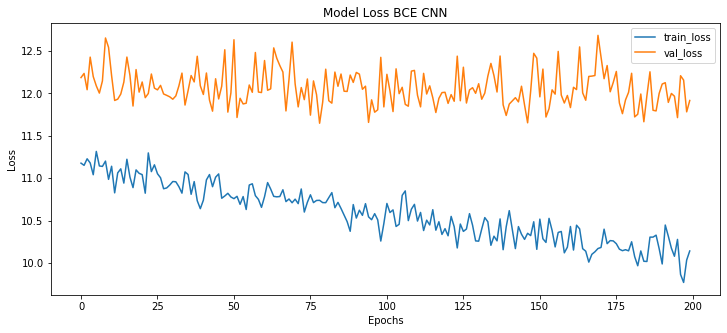

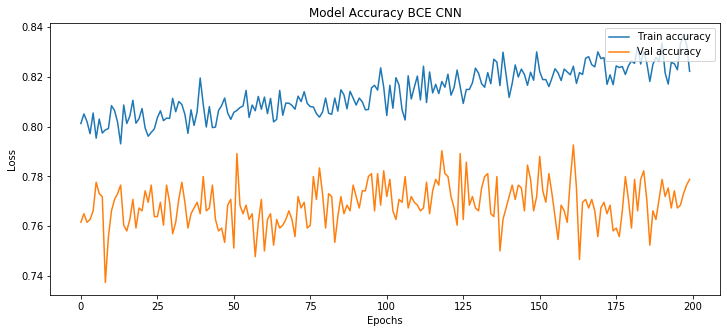

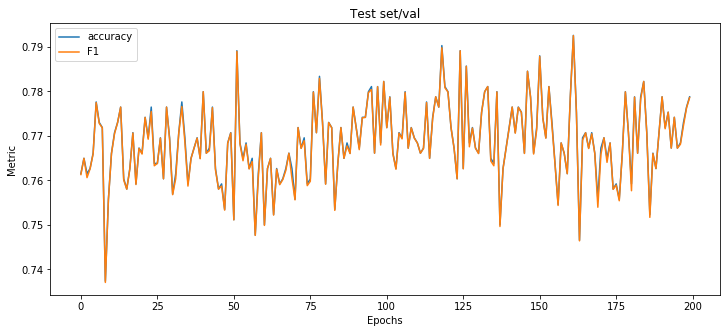

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.884696,0.676824,0.766924,0.738697,0.726581,0.732534
Confirmed,0.581950,0.836066,0.686239,0.738697,0.726581,0.732534


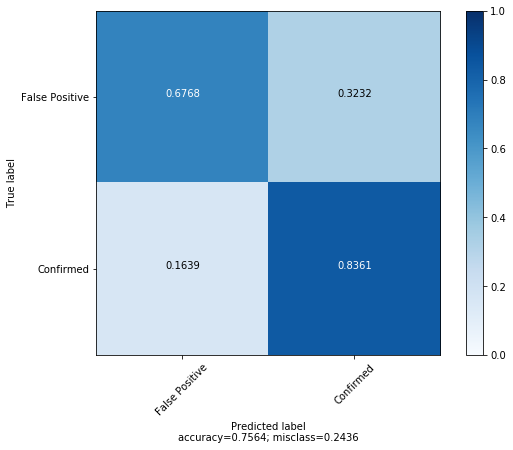

{'Precision raw': array([0.88469602, 0.58195021]),
 'Recall raw': array([0.67682438, 0.83606557]),
 'F1 raw': array([0.76692413, 0.68623853]),
 'F1 weighted': 0.7386967880170033,
 'F1 macro': 0.7265813287538192,
 'F1 micro': 0.732533889468196,
 'Confusion Matrix': array([[844, 403],
        [110, 561]])}

In [27]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.6)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 628us/step - loss: 10.3805 - acc: 0.8001 - val_loss: 11.6454 - val_acc: 0.7742
Epoch 2/200
7810/7810 [==============================] - 2s 259us/step - loss: 10.3244 - acc: 0.8003 - val_loss: 11.4131 - val_acc: 0.7730
Epoch 3/200
7810/7810 [==============================] - 2s 251us/step - loss: 10.3593 - acc: 0.8049 - val_loss: 11.7431 - val_acc: 0.7581
Epoch 4/200
7810/7810 [==============================] - 2s 261us/step - loss: 10.3430 - acc: 0.7972 - val_loss: 12.1944 - val_acc: 0.7488
Epoch 5/200
7810/7810 [==============================] - 2s 252us/step - loss: 10.3323 - acc: 0.7976 - val_loss: 11.7937 - val_acc: 0.7650
Epoch 6/200
7810/7810 [==============================] - 2s 254us/step - loss: 10.3716 - acc: 0.7954 - val_loss: 11.8603 - val_acc: 0.7569
Epoch 7/200
7810/7810 [==============================] - 2s 249us/step - loss: 10.3153 - acc: 0.8067 - val_loss: 11.623

Epoch 35/200
7810/7810 [==============================] - 2s 232us/step - loss: 10.3126 - acc: 0.7983 - val_loss: 12.0765 - val_acc: 0.7742
Epoch 36/200
7810/7810 [==============================] - 2s 237us/step - loss: 10.1410 - acc: 0.8028 - val_loss: 11.8423 - val_acc: 0.7673
Epoch 37/200
7810/7810 [==============================] - 2s 234us/step - loss: 10.1501 - acc: 0.8032 - val_loss: 11.5548 - val_acc: 0.7753
Epoch 38/200
7810/7810 [==============================] - 2s 234us/step - loss: 9.9440 - acc: 0.8099 - val_loss: 11.9865 - val_acc: 0.7604
Epoch 39/200
7810/7810 [==============================] - 2s 236us/step - loss: 10.1299 - acc: 0.8078 - val_loss: 11.3982 - val_acc: 0.7627
Epoch 40/200
7810/7810 [==============================] - 2s 231us/step - loss: 10.1111 - acc: 0.8056 - val_loss: 11.6868 - val_acc: 0.7592
Epoch 41/200
7810/7810 [==============================] - 2s 234us/step - loss: 10.1810 - acc: 0.7936 - val_loss: 11.7598 - val_acc: 0.7604
Epoch 42/200
7810/781

Epoch 69/200
7810/7810 [==============================] - 2s 233us/step - loss: 10.0738 - acc: 0.8018 - val_loss: 12.0444 - val_acc: 0.7604
Epoch 70/200
7810/7810 [==============================] - 2s 234us/step - loss: 9.8255 - acc: 0.8142 - val_loss: 11.5089 - val_acc: 0.7696
Epoch 71/200
7810/7810 [==============================] - 2s 234us/step - loss: 9.9228 - acc: 0.8097 - val_loss: 11.5322 - val_acc: 0.7592
Epoch 72/200
7810/7810 [==============================] - 2s 236us/step - loss: 9.9323 - acc: 0.8077 - val_loss: 11.4775 - val_acc: 0.7730
Epoch 73/200
7810/7810 [==============================] - 2s 235us/step - loss: 10.1053 - acc: 0.8040 - val_loss: 11.5898 - val_acc: 0.7661
Epoch 74/200
7810/7810 [==============================] - 2s 235us/step - loss: 9.8294 - acc: 0.8064 - val_loss: 11.5756 - val_acc: 0.7650
Epoch 75/200
7810/7810 [==============================] - 2s 239us/step - loss: 9.9857 - acc: 0.8133 - val_loss: 11.2888 - val_acc: 0.7730
Epoch 76/200
7810/7810 [=

Epoch 103/200
7810/7810 [==============================] - 2s 234us/step - loss: 9.9483 - acc: 0.8134 - val_loss: 11.6946 - val_acc: 0.7535
Epoch 104/200
7810/7810 [==============================] - 2s 235us/step - loss: 9.7116 - acc: 0.8123 - val_loss: 11.6537 - val_acc: 0.7742
Epoch 105/200
7810/7810 [==============================] - 2s 243us/step - loss: 9.6955 - acc: 0.8200 - val_loss: 11.5220 - val_acc: 0.7684
Epoch 106/200
7810/7810 [==============================] - 2s 237us/step - loss: 9.8970 - acc: 0.8137 - val_loss: 12.0344 - val_acc: 0.7638
Epoch 107/200
7810/7810 [==============================] - 2s 253us/step - loss: 9.8182 - acc: 0.8142 - val_loss: 11.5666 - val_acc: 0.7788
Epoch 108/200
7810/7810 [==============================] - 2s 273us/step - loss: 9.4924 - acc: 0.8174 - val_loss: 12.2820 - val_acc: 0.7696
Epoch 109/200
7810/7810 [==============================] - 2s 233us/step - loss: 10.1024 - acc: 0.8120 - val_loss: 11.9459 - val_acc: 0.7696
Epoch 110/200
7810/

Epoch 137/200
7810/7810 [==============================] - 2s 237us/step - loss: 9.4938 - acc: 0.8207 - val_loss: 11.5125 - val_acc: 0.7696
Epoch 138/200
7810/7810 [==============================] - 2s 235us/step - loss: 9.8877 - acc: 0.8152 - val_loss: 11.6852 - val_acc: 0.7696
Epoch 139/200
7810/7810 [==============================] - 2s 239us/step - loss: 9.9146 - acc: 0.8061 - val_loss: 11.5646 - val_acc: 0.7615
Epoch 140/200
7810/7810 [==============================] - 2s 233us/step - loss: 9.7351 - acc: 0.8204 - val_loss: 11.9071 - val_acc: 0.7581
Epoch 141/200
7810/7810 [==============================] - 2s 232us/step - loss: 9.8096 - acc: 0.8142 - val_loss: 11.9827 - val_acc: 0.7661
Epoch 142/200
7810/7810 [==============================] - 2s 243us/step - loss: 9.8237 - acc: 0.8124 - val_loss: 11.3688 - val_acc: 0.7696
Epoch 143/200
7810/7810 [==============================] - 2s 252us/step - loss: 9.5755 - acc: 0.8219 - val_loss: 11.7740 - val_acc: 0.7776
Epoch 144/200
7810/7

Epoch 171/200
7810/7810 [==============================] - 2s 238us/step - loss: 9.7207 - acc: 0.8159 - val_loss: 11.6642 - val_acc: 0.7765
Epoch 172/200
7810/7810 [==============================] - 2s 248us/step - loss: 9.5583 - acc: 0.8196 - val_loss: 11.3302 - val_acc: 0.7753
Epoch 173/200
7810/7810 [==============================] - 2s 232us/step - loss: 9.4617 - acc: 0.8197 - val_loss: 11.8458 - val_acc: 0.7788
Epoch 174/200
7810/7810 [==============================] - 2s 235us/step - loss: 9.4620 - acc: 0.8237 - val_loss: 11.4050 - val_acc: 0.7753
Epoch 175/200
7810/7810 [==============================] - 2s 236us/step - loss: 9.8296 - acc: 0.8143 - val_loss: 11.5508 - val_acc: 0.7765
Epoch 176/200
7810/7810 [==============================] - 2s 238us/step - loss: 9.5390 - acc: 0.8237 - val_loss: 11.5089 - val_acc: 0.7673
Epoch 177/200
7810/7810 [==============================] - 2s 244us/step - loss: 9.6603 - acc: 0.8161 - val_loss: 11.7293 - val_acc: 0.7776
Epoch 178/200
7810/7

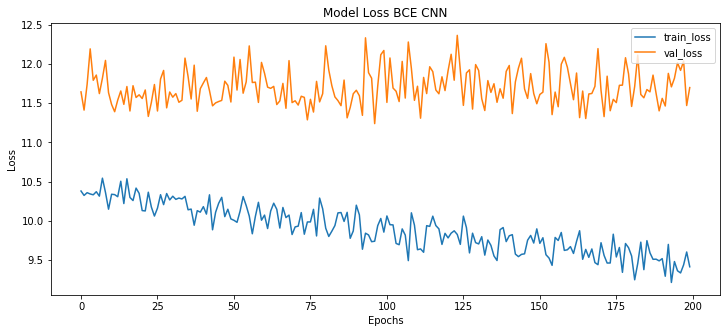

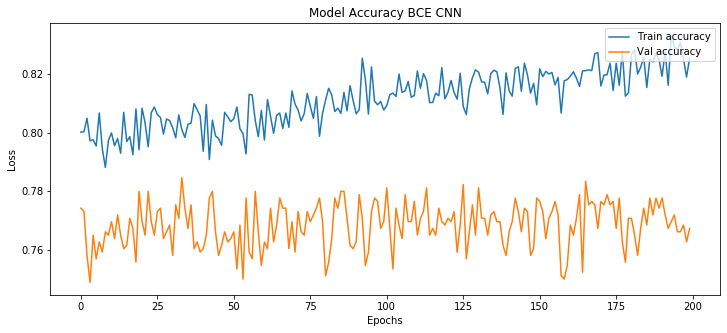

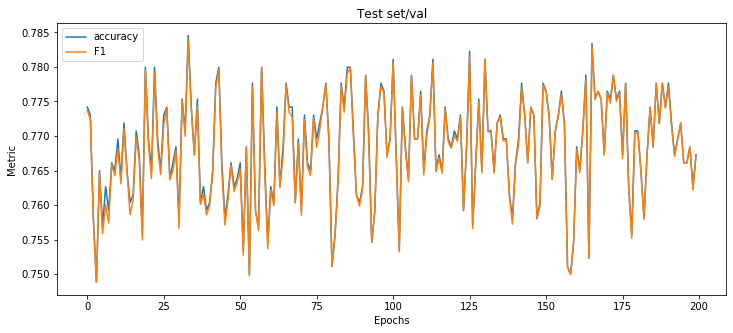

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.897492,0.659984,0.760628,0.735987,0.72541,0.729927
Confirmed,0.576424,0.859911,0.690191,0.735987,0.72541,0.729927


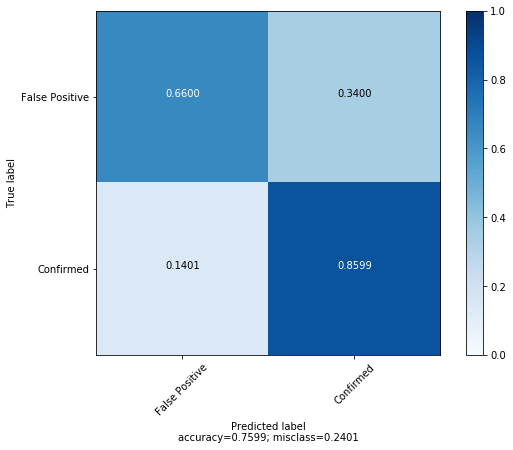

{'Precision raw': array([0.89749182, 0.57642358]),
 'Recall raw': array([0.65998396, 0.85991058]),
 'F1 raw': array([0.76062847, 0.69019139]),
 'F1 weighted': 0.7359865056883745,
 'F1 macro': 0.7254099266819376,
 'F1 micro': 0.72992700729927,
 'Confusion Matrix': array([[823, 424],
        [ 94, 577]])}

In [28]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.65)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 668us/step - loss: 10.8052 - acc: 0.8254 - val_loss: 12.7783 - val_acc: 0.7558
Epoch 2/200
7810/7810 [==============================] - 2s 252us/step - loss: 10.5196 - acc: 0.8312 - val_loss: 12.6936 - val_acc: 0.7535
Epoch 3/200
7810/7810 [==============================] - 2s 261us/step - loss: 10.6075 - acc: 0.8342 - val_loss: 12.5006 - val_acc: 0.7523
Epoch 4/200
7810/7810 [==============================] - 2s 249us/step - loss: 10.7219 - acc: 0.8334 - val_loss: 12.4303 - val_acc: 0.7592
Epoch 5/200
7810/7810 [==============================] - 2s 250us/step - loss: 10.3879 - acc: 0.8373 - val_loss: 12.5625 - val_acc: 0.7650
Epoch 6/200
7810/7810 [==============================] - 2s 237us/step - loss: 10.4693 - acc: 0.8360 - val_loss: 12.4271 - val_acc: 0.7604
Epoch 7/200
7810/7810 [==============================] - 2s 249us/step - loss: 10.6924 - acc: 0.8297 - val_loss: 12.422

Epoch 35/200
7810/7810 [==============================] - 2s 232us/step - loss: 9.9765 - acc: 0.8447 - val_loss: 12.4288 - val_acc: 0.7523
Epoch 36/200
7810/7810 [==============================] - 2s 235us/step - loss: 10.3927 - acc: 0.8421 - val_loss: 12.4847 - val_acc: 0.7707
Epoch 37/200
7810/7810 [==============================] - 2s 235us/step - loss: 10.4193 - acc: 0.8438 - val_loss: 12.0809 - val_acc: 0.7650
Epoch 38/200
7810/7810 [==============================] - 2s 236us/step - loss: 10.3422 - acc: 0.8434 - val_loss: 12.5224 - val_acc: 0.7546
Epoch 39/200
7810/7810 [==============================] - 2s 240us/step - loss: 10.2708 - acc: 0.8407 - val_loss: 12.5475 - val_acc: 0.7673
Epoch 40/200
7810/7810 [==============================] - 2s 245us/step - loss: 10.3755 - acc: 0.8405 - val_loss: 12.7781 - val_acc: 0.7535
Epoch 41/200
7810/7810 [==============================] - 2s 236us/step - loss: 10.2202 - acc: 0.8403 - val_loss: 12.1169 - val_acc: 0.7753
Epoch 42/200
7810/781

Epoch 69/200
7810/7810 [==============================] - 2s 235us/step - loss: 10.2596 - acc: 0.8421 - val_loss: 12.6252 - val_acc: 0.7673
Epoch 70/200
7810/7810 [==============================] - 2s 232us/step - loss: 10.2947 - acc: 0.8391 - val_loss: 12.3577 - val_acc: 0.7581
Epoch 71/200
7810/7810 [==============================] - 2s 239us/step - loss: 10.2521 - acc: 0.8408 - val_loss: 12.4626 - val_acc: 0.7730
Epoch 72/200
7810/7810 [==============================] - 2s 235us/step - loss: 10.0678 - acc: 0.8490 - val_loss: 12.4830 - val_acc: 0.7719
Epoch 73/200
7810/7810 [==============================] - 2s 237us/step - loss: 10.1314 - acc: 0.8437 - val_loss: 12.5769 - val_acc: 0.7753
Epoch 74/200
7810/7810 [==============================] - 2s 237us/step - loss: 9.9038 - acc: 0.8498 - val_loss: 13.1455 - val_acc: 0.7558
Epoch 75/200
7810/7810 [==============================] - 2s 239us/step - loss: 10.0478 - acc: 0.8469 - val_loss: 12.8239 - val_acc: 0.7592
Epoch 76/200
7810/781

Epoch 103/200
7810/7810 [==============================] - 2s 257us/step - loss: 9.9577 - acc: 0.8472 - val_loss: 12.5602 - val_acc: 0.7742
Epoch 104/200
7810/7810 [==============================] - 2s 242us/step - loss: 9.9501 - acc: 0.8512 - val_loss: 12.6640 - val_acc: 0.7650
Epoch 105/200
7810/7810 [==============================] - 2s 243us/step - loss: 10.0943 - acc: 0.8465 - val_loss: 12.7255 - val_acc: 0.7604
Epoch 106/200
7810/7810 [==============================] - 2s 237us/step - loss: 9.8911 - acc: 0.8479 - val_loss: 12.6283 - val_acc: 0.7661
Epoch 107/200
7810/7810 [==============================] - 2s 237us/step - loss: 10.0379 - acc: 0.8474 - val_loss: 12.4940 - val_acc: 0.7661
Epoch 108/200
7810/7810 [==============================] - 2s 239us/step - loss: 9.8611 - acc: 0.8531 - val_loss: 12.3591 - val_acc: 0.7765
Epoch 109/200
7810/7810 [==============================] - 2s 237us/step - loss: 10.0510 - acc: 0.8460 - val_loss: 12.6331 - val_acc: 0.7696
Epoch 110/200
781

Epoch 137/200
7810/7810 [==============================] - 2s 237us/step - loss: 10.0172 - acc: 0.8414 - val_loss: 12.1618 - val_acc: 0.7857
Epoch 138/200
7810/7810 [==============================] - 2s 240us/step - loss: 9.7194 - acc: 0.8521 - val_loss: 12.5713 - val_acc: 0.7800
Epoch 139/200
7810/7810 [==============================] - 2s 238us/step - loss: 9.8422 - acc: 0.8531 - val_loss: 12.7530 - val_acc: 0.7615
Epoch 140/200
7810/7810 [==============================] - 2s 237us/step - loss: 9.6801 - acc: 0.8528 - val_loss: 12.5735 - val_acc: 0.7719
Epoch 141/200
7810/7810 [==============================] - 2s 244us/step - loss: 9.7357 - acc: 0.8544 - val_loss: 12.7536 - val_acc: 0.7638
Epoch 142/200
7810/7810 [==============================] - 2s 232us/step - loss: 10.0009 - acc: 0.8471 - val_loss: 12.2000 - val_acc: 0.7776
Epoch 143/200
7810/7810 [==============================] - 2s 232us/step - loss: 9.9676 - acc: 0.8508 - val_loss: 12.4932 - val_acc: 0.7684
Epoch 144/200
7810

Epoch 171/200
7810/7810 [==============================] - 2s 239us/step - loss: 9.5799 - acc: 0.8543 - val_loss: 12.8422 - val_acc: 0.7523
Epoch 172/200
7810/7810 [==============================] - 2s 232us/step - loss: 10.0065 - acc: 0.8471 - val_loss: 13.0845 - val_acc: 0.7523
Epoch 173/200
7810/7810 [==============================] - 2s 238us/step - loss: 9.8315 - acc: 0.8508 - val_loss: 12.4128 - val_acc: 0.7730
Epoch 174/200
7810/7810 [==============================] - 2s 235us/step - loss: 9.8113 - acc: 0.8493 - val_loss: 12.1705 - val_acc: 0.7615
Epoch 175/200
7810/7810 [==============================] - 2s 236us/step - loss: 9.5605 - acc: 0.8528 - val_loss: 12.3802 - val_acc: 0.7707
Epoch 176/200
7810/7810 [==============================] - 2s 237us/step - loss: 9.6607 - acc: 0.8556 - val_loss: 12.4371 - val_acc: 0.7638
Epoch 177/200
7810/7810 [==============================] - 2s 232us/step - loss: 9.7702 - acc: 0.8538 - val_loss: 12.6722 - val_acc: 0.7581
Epoch 178/200
7810/

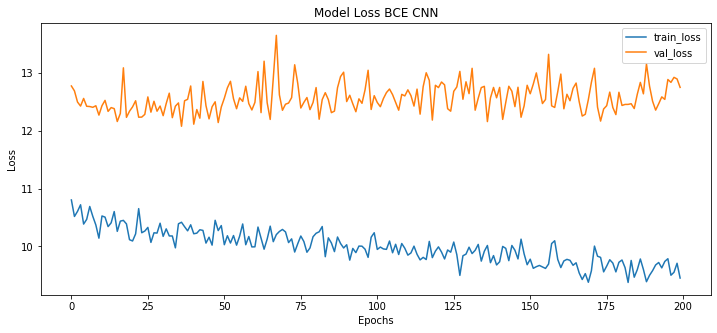

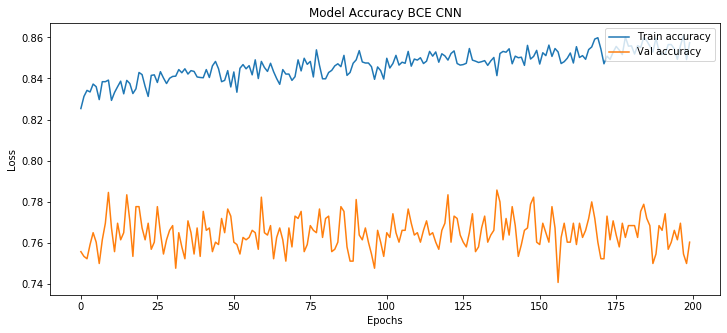

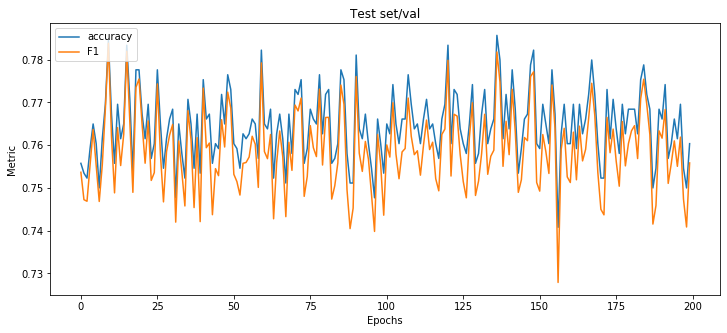

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.840391,0.827586,0.833939,0.786388,0.765978,0.785714
Confirmed,0.688406,0.707899,0.698016,0.786388,0.765978,0.785714


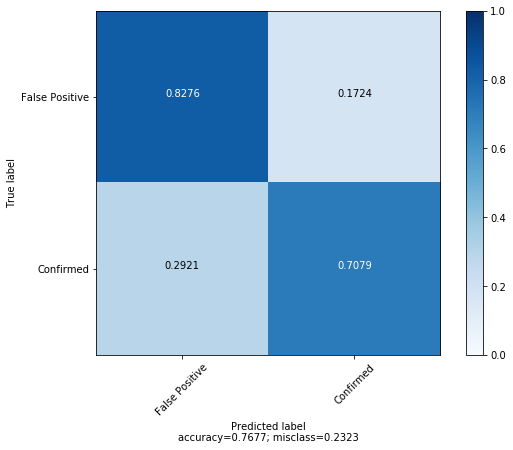

{'Precision raw': array([0.84039088, 0.6884058 ]),
 'Recall raw': array([0.82758621, 0.70789866]),
 'F1 raw': array([0.83393939, 0.69801616]),
 'F1 weighted': 0.7863875238158854,
 'F1 macro': 0.765977779262129,
 'F1 micro': 0.7857142857142857,
 'Confusion Matrix': array([[1032,  215],
        [ 196,  475]])}

In [29]:
#factor 0.2 y pat 10
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

## Hyperkeras para decisiones
* Batch size
* alpha
* Factor lr decay y patience

In [17]:
def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    channel_1 = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d15.npy')  
    channel_2 = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d15.npy')  
    channel_3 = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/time_channel_30.npy')  

    x_all = []
    for i in range(channel_1.shape[0]):
        combined_image = np.dstack((channel_1[i],channel_3[i]))
        x_all.append(combined_image)
    x_all = np.asarray(x_all)

    x_all2 = []
    for i in range(channel_1.shape[0]):
        combined_image = np.dstack((channel_2[i],channel_3[i]))
        x_all2.append(combined_image)
    x_all2 = np.asarray(x_all2)

    fold ="../../KOI_Data/"
    df_sets = pd.read_csv(fold+"/koi_sets.csv") 
    mask_train = (df_sets["Set"] == "Train").values
    mask_test = (df_sets["Set"] == "Test").values

    df_meta = pd.read_csv(fold+"/koi_metadata.csv")
    df_meta_train = df_meta[mask_train]
    df_meta_test = df_meta[mask_test]
    y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
    y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_val, counts_val = np.unique(y_val, return_counts=True)

    x_train1 = x_all[mask_train]
    x_train2 = x_all2[mask_train]
    x_train = np.concatenate([x_train1,x_train2]) #concat

    x_val = x_all[mask_test]

    if x_train.shape[0] != y_train.shape[0]:
        y_train = np.tile(y_train, (2))
    
    return x_train, y_train, x_val, y_val


import keras
from keras.layers import *
from keras.models import Sequential
from keras.utils import np_utils

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

###### binary

In [18]:
def create_model(x_train, y_train, x_test, y_test):
    ####### PARA MEDIR F1 AL FINA LDE EPOCH ###########
    class Metrics(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.val_f1s = []

        def on_epoch_end(self, batch, logs={}):
            predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
            targ = np.squeeze(self.validation_data[1])
            f1s = f1_score(targ, predict, average='macro')
            self.val_f1s.append(f1s)
            #print(" - val_f1: %f " %(f1s))
            return
    def binary_focal_loss(gamma=2., alpha=.25):
        """
        Binary form of focal loss.
          FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
          where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
        References:
            https://arxiv.org/pdf/1708.02002.pdf
        Usage:
         model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
        """
        def binary_focal_loss_fixed(y_true, y_pred):
            """
            :param y_true: A tensor of the same shape as `y_pred`
            :param y_pred:  A tensor resulting from a sigmoid
            :return: Output tensor.
            """
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

            epsilon = K.epsilon()
            # clip to prevent NaN's and Inf's
            pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
            pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

            return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
                   -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

        return binary_focal_loss_fixed

    
    #elejir modelo?
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    #elejir global?
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=binary_focal_loss(alpha={{uniform(0.4,0.95)}}, 
                                         gamma={{choice([0.5, 1, 2 ,5])}}),
                                                optimizer="adam")
    #model.compile(loss='binary_crossentropy',optimizer='Adam')
    
    metrics = Metrics()
    result = model.fit(x_train, y_train,
                  batch_size={{choice([64, 128, 256 ,512])}},
                  epochs=200,
                  verbose=0,
                  validation_split=0.1, callbacks=[metrics])

    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(metrics.val_f1s) #np.amax(result.history['val_f1']) 
    print('Best validation metric of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from scipy.stats import norm
except:
    pass

try:
    import itertools
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.metrics import mean_squared_error as mse
except:
    pass

try:
    from sklearn.utils import class_weight
except:
    pass

try:
    from astropy.io import fits
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import os, sys
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, accuracy_score
except:
    pass

try:
    from keras.regularizers import l2
except:
    pass

try:
    from keras.activations import tanh
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import *
except:
    pass

try:
    from keras.losses import catego

Best validation metric of epoch:                   
0.7257909009973702                                 
 20%|██        | 1/5 [06:11<24:46, 371.53s/it, best loss: -0.7257909009973702]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                              
0.6836294635156115                                                            
Best validation metric of epoch:                                              
0.7705628861465181                                                            
Best validation metric of epoch:                                              
0.7472389991371873                                                            
Best validation metric of epoch:                                              
0.722116116039424                                                             
100%|██████████| 5/5 [32:14<00:00, 396.09s/it, best loss: -0.7705628861465181]
{'alpha': 0.5587643947464003, 'batch_size': 2, 'gamma': 1}


,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.833751,0.800321,0.816694,0.768229,0.747427,0.766423
Confirmed,0.654646,0.703428,0.678161,0.768229,0.747427,0.766423


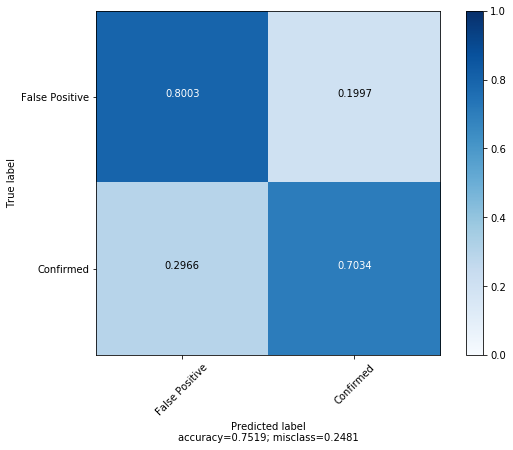

{'Precision raw': array([0.83375104, 0.65464632]),
 'Recall raw': array([0.80032077, 0.70342772]),
 'F1 raw': array([0.81669394, 0.67816092]),
 'F1 weighted': 0.7682290540251994,
 'F1 macro': 0.7474274319468743,
 'F1 micro': 0.7664233576642334,
 'Confusion Matrix': array([[998, 249],
        [199, 472]])}

In [32]:
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=1,
                                          trials=Trials(),
                                     notebook_name='el_mejor_76')
print(best_run)

x_train, y_train, x_val, y_val = data()

predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1152)              0         
__________

Epoch 28/500
7810/7810 [==============================] - 2s 239us/step - loss: 16.0417 - acc: 0.6894 - val_loss: 16.2084 - val_acc: 0.6705
Epoch 29/500
7810/7810 [==============================] - 2s 239us/step - loss: 15.9845 - acc: 0.6985 - val_loss: 16.1992 - val_acc: 0.6694
Epoch 30/500
7810/7810 [==============================] - 2s 242us/step - loss: 15.8160 - acc: 0.6941 - val_loss: 15.9821 - val_acc: 0.6832
Epoch 31/500
7810/7810 [==============================] - 2s 246us/step - loss: 15.8595 - acc: 0.6955 - val_loss: 15.7841 - val_acc: 0.7016
Epoch 32/500
7810/7810 [==============================] - 2s 243us/step - loss: 15.8408 - acc: 0.6968 - val_loss: 16.0243 - val_acc: 0.6774
Epoch 33/500
7810/7810 [==============================] - 2s 240us/step - loss: 15.8544 - acc: 0.6941 - val_loss: 16.1579 - val_acc: 0.6820
Epoch 34/500
7810/7810 [==============================] - 2s 243us/step - loss: 15.7366 - acc: 0.6994 - val_loss: 15.6815 - val_acc: 0.6924
Epoch 35/500
7810/78

Epoch 62/500
7810/7810 [==============================] - 2s 243us/step - loss: 14.9220 - acc: 0.7282 - val_loss: 15.5432 - val_acc: 0.6820
Epoch 63/500
7810/7810 [==============================] - 2s 240us/step - loss: 14.9626 - acc: 0.7216 - val_loss: 15.3542 - val_acc: 0.7143
Epoch 64/500
7810/7810 [==============================] - 2s 239us/step - loss: 14.9362 - acc: 0.7204 - val_loss: 15.4152 - val_acc: 0.6878
Epoch 65/500
7810/7810 [==============================] - 2s 243us/step - loss: 14.9477 - acc: 0.7255 - val_loss: 14.9481 - val_acc: 0.7097
Epoch 66/500
7810/7810 [==============================] - 2s 243us/step - loss: 14.8591 - acc: 0.7216 - val_loss: 15.3512 - val_acc: 0.6947
Epoch 67/500
7810/7810 [==============================] - 2s 240us/step - loss: 14.9121 - acc: 0.7216 - val_loss: 15.0556 - val_acc: 0.7097
Epoch 68/500
7810/7810 [==============================] - 2s 240us/step - loss: 14.9349 - acc: 0.7248 - val_loss: 15.7122 - val_acc: 0.6717
Epoch 69/500
7810/78

Epoch 96/500
7810/7810 [==============================] - 2s 248us/step - loss: 13.9764 - acc: 0.7529 - val_loss: 14.2894 - val_acc: 0.7488
Epoch 97/500
7810/7810 [==============================] - 2s 244us/step - loss: 14.0409 - acc: 0.7466 - val_loss: 15.7193 - val_acc: 0.6774
Epoch 98/500
7810/7810 [==============================] - 2s 244us/step - loss: 14.1120 - acc: 0.7487 - val_loss: 14.1496 - val_acc: 0.7304
Epoch 99/500
7810/7810 [==============================] - 2s 244us/step - loss: 13.9032 - acc: 0.7544 - val_loss: 14.6901 - val_acc: 0.7270
Epoch 100/500
7810/7810 [==============================] - 2s 241us/step - loss: 14.0040 - acc: 0.7517 - val_loss: 14.5897 - val_acc: 0.7281
Epoch 101/500
7810/7810 [==============================] - 2s 242us/step - loss: 13.9737 - acc: 0.7580 - val_loss: 14.2684 - val_acc: 0.7350
Epoch 102/500
7810/7810 [==============================] - 2s 245us/step - loss: 13.9352 - acc: 0.7538 - val_loss: 14.3742 - val_acc: 0.7327
Epoch 103/500
781

Epoch 130/500
7810/7810 [==============================] - 2s 240us/step - loss: 13.4780 - acc: 0.7647 - val_loss: 14.0700 - val_acc: 0.7419
Epoch 131/500
7810/7810 [==============================] - 2s 240us/step - loss: 13.5270 - acc: 0.7672 - val_loss: 14.2323 - val_acc: 0.7304
Epoch 132/500
7810/7810 [==============================] - 2s 240us/step - loss: 13.4314 - acc: 0.7684 - val_loss: 14.0784 - val_acc: 0.7327
Epoch 133/500
7810/7810 [==============================] - 2s 240us/step - loss: 13.4294 - acc: 0.7639 - val_loss: 14.4045 - val_acc: 0.7166
Epoch 134/500
7810/7810 [==============================] - 2s 240us/step - loss: 13.1968 - acc: 0.7752 - val_loss: 14.6906 - val_acc: 0.7039
Epoch 135/500
7810/7810 [==============================] - 2s 239us/step - loss: 13.2802 - acc: 0.7681 - val_loss: 14.4374 - val_acc: 0.7154
Epoch 136/500
7810/7810 [==============================] - 2s 240us/step - loss: 13.3485 - acc: 0.7688 - val_loss: 14.0010 - val_acc: 0.7408
Epoch 137/500

Epoch 164/500
7810/7810 [==============================] - 2s 243us/step - loss: 13.0390 - acc: 0.7782 - val_loss: 14.8383 - val_acc: 0.6924
Epoch 165/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.8296 - acc: 0.7803 - val_loss: 13.8666 - val_acc: 0.7454
Epoch 166/500
7810/7810 [==============================] - 2s 239us/step - loss: 13.0469 - acc: 0.7808 - val_loss: 14.0107 - val_acc: 0.7373
Epoch 167/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.7767 - acc: 0.7839 - val_loss: 13.6351 - val_acc: 0.7569
Epoch 168/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.8448 - acc: 0.7854 - val_loss: 13.8191 - val_acc: 0.7488
Epoch 169/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.8141 - acc: 0.7812 - val_loss: 13.7980 - val_acc: 0.7362
Epoch 170/500
7810/7810 [==============================] - 2s 240us/step - loss: 12.7691 - acc: 0.7862 - val_loss: 13.5985 - val_acc: 0.7512
Epoch 171/500

Epoch 198/500
7810/7810 [==============================] - 2s 240us/step - loss: 12.4037 - acc: 0.7908 - val_loss: 13.6563 - val_acc: 0.7488
Epoch 199/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.4544 - acc: 0.7828 - val_loss: 13.5951 - val_acc: 0.7581
Epoch 200/500
7810/7810 [==============================] - 2s 241us/step - loss: 12.5374 - acc: 0.7883 - val_loss: 13.9044 - val_acc: 0.7396
Epoch 201/500
7810/7810 [==============================] - 2s 260us/step - loss: 12.3972 - acc: 0.7903 - val_loss: 14.0136 - val_acc: 0.7419
Epoch 202/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.5337 - acc: 0.7919 - val_loss: 13.9109 - val_acc: 0.7385
Epoch 203/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.4510 - acc: 0.7931 - val_loss: 13.5550 - val_acc: 0.7523
Epoch 204/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.3944 - acc: 0.7903 - val_loss: 14.1031 - val_acc: 0.7350
Epoch 205/500

Epoch 232/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.9404 - acc: 0.8012 - val_loss: 13.3943 - val_acc: 0.7546
Epoch 233/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.0090 - acc: 0.8009 - val_loss: 13.6782 - val_acc: 0.7615
Epoch 234/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.2257 - acc: 0.7985 - val_loss: 13.9195 - val_acc: 0.7327
Epoch 235/500
7810/7810 [==============================] - 2s 240us/step - loss: 12.0474 - acc: 0.8008 - val_loss: 13.3801 - val_acc: 0.7592
Epoch 236/500
7810/7810 [==============================] - 2s 239us/step - loss: 12.1939 - acc: 0.7972 - val_loss: 13.8922 - val_acc: 0.7523
Epoch 237/500
7810/7810 [==============================] - 2s 243us/step - loss: 12.1436 - acc: 0.7990 - val_loss: 13.2681 - val_acc: 0.7730
Epoch 238/500
7810/7810 [==============================] - 2s 247us/step - loss: 11.9547 - acc: 0.7986 - val_loss: 13.0481 - val_acc: 0.7765
Epoch 239/500

Epoch 266/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.7346 - acc: 0.8064 - val_loss: 13.6637 - val_acc: 0.7546
Epoch 267/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.4844 - acc: 0.8132 - val_loss: 13.8980 - val_acc: 0.7385
Epoch 268/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.9523 - acc: 0.8050 - val_loss: 13.3882 - val_acc: 0.7535
Epoch 269/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.7986 - acc: 0.8064 - val_loss: 13.3682 - val_acc: 0.7535
Epoch 270/500
7810/7810 [==============================] - 2s 239us/step - loss: 11.5980 - acc: 0.8070 - val_loss: 13.6824 - val_acc: 0.7535
Epoch 271/500
7810/7810 [==============================] - 2s 239us/step - loss: 11.6790 - acc: 0.8029 - val_loss: 13.8011 - val_acc: 0.7477
Epoch 272/500
7810/7810 [==============================] - 2s 239us/step - loss: 11.7624 - acc: 0.8065 - val_loss: 13.1647 - val_acc: 0.7684
Epoch 273/500

Epoch 300/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.2484 - acc: 0.8174 - val_loss: 13.6718 - val_acc: 0.7581
Epoch 301/500
7810/7810 [==============================] - 2s 241us/step - loss: 11.5391 - acc: 0.8128 - val_loss: 13.3100 - val_acc: 0.7592
Epoch 302/500
7810/7810 [==============================] - 2s 241us/step - loss: 11.5325 - acc: 0.8136 - val_loss: 13.7873 - val_acc: 0.7500
Epoch 303/500
7810/7810 [==============================] - 2s 249us/step - loss: 11.3531 - acc: 0.8175 - val_loss: 13.6121 - val_acc: 0.7535
Epoch 304/500
7810/7810 [==============================] - 2s 249us/step - loss: 11.5510 - acc: 0.8124 - val_loss: 13.4587 - val_acc: 0.7535
Epoch 305/500
7810/7810 [==============================] - 2s 248us/step - loss: 11.2986 - acc: 0.8224 - val_loss: 13.8667 - val_acc: 0.7592
Epoch 306/500
7810/7810 [==============================] - 2s 245us/step - loss: 11.2876 - acc: 0.8131 - val_loss: 13.6052 - val_acc: 0.7465
Epoch 307/500

Epoch 334/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.8986 - acc: 0.8303 - val_loss: 13.5871 - val_acc: 0.7673
Epoch 335/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.8942 - acc: 0.8237 - val_loss: 14.0051 - val_acc: 0.7396
Epoch 336/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.3783 - acc: 0.8175 - val_loss: 13.6471 - val_acc: 0.7581
Epoch 337/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.9760 - acc: 0.8269 - val_loss: 13.8195 - val_acc: 0.7558
Epoch 338/500
7810/7810 [==============================] - 2s 241us/step - loss: 11.2181 - acc: 0.8229 - val_loss: 13.8574 - val_acc: 0.7419
Epoch 339/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.0950 - acc: 0.8239 - val_loss: 13.7652 - val_acc: 0.7523
Epoch 340/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.9340 - acc: 0.8236 - val_loss: 13.7436 - val_acc: 0.7465
Epoch 341/500

Epoch 368/500
7810/7810 [==============================] - 2s 241us/step - loss: 11.1734 - acc: 0.8222 - val_loss: 14.0374 - val_acc: 0.7327
Epoch 369/500
7810/7810 [==============================] - 2s 241us/step - loss: 10.8713 - acc: 0.8224 - val_loss: 13.5681 - val_acc: 0.7373
Epoch 370/500
7810/7810 [==============================] - 2s 241us/step - loss: 10.9237 - acc: 0.8201 - val_loss: 13.8161 - val_acc: 0.7454
Epoch 371/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.8196 - acc: 0.8300 - val_loss: 13.8474 - val_acc: 0.7442
Epoch 372/500
7810/7810 [==============================] - 2s 240us/step - loss: 11.0038 - acc: 0.8302 - val_loss: 14.2895 - val_acc: 0.7523
Epoch 373/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.8227 - acc: 0.8297 - val_loss: 13.9976 - val_acc: 0.7442
Epoch 374/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.7854 - acc: 0.8260 - val_loss: 13.6504 - val_acc: 0.7500
Epoch 375/500

Epoch 402/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.7204 - acc: 0.8323 - val_loss: 14.4983 - val_acc: 0.7327
Epoch 403/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.8463 - acc: 0.8287 - val_loss: 13.5004 - val_acc: 0.7535
Epoch 404/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.7623 - acc: 0.8312 - val_loss: 13.6687 - val_acc: 0.7696
Epoch 405/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.8375 - acc: 0.8324 - val_loss: 13.7987 - val_acc: 0.7500
Epoch 406/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.7926 - acc: 0.8325 - val_loss: 13.9801 - val_acc: 0.7627
Epoch 407/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.5698 - acc: 0.8350 - val_loss: 13.6217 - val_acc: 0.7488
Epoch 408/500
7810/7810 [==============================] - 2s 241us/step - loss: 10.5998 - acc: 0.8343 - val_loss: 13.6570 - val_acc: 0.7604
Epoch 409/500

Epoch 436/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.5935 - acc: 0.8379 - val_loss: 14.2701 - val_acc: 0.7488
Epoch 437/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.4010 - acc: 0.8380 - val_loss: 14.0958 - val_acc: 0.7512
Epoch 438/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.6731 - acc: 0.8279 - val_loss: 13.8907 - val_acc: 0.7465
Epoch 439/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.5075 - acc: 0.8364 - val_loss: 14.0873 - val_acc: 0.7442
Epoch 440/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.2645 - acc: 0.8402 - val_loss: 14.3891 - val_acc: 0.7442
Epoch 441/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.3687 - acc: 0.8401 - val_loss: 14.3876 - val_acc: 0.7396
Epoch 442/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.6005 - acc: 0.8359 - val_loss: 14.1104 - val_acc: 0.7488
Epoch 443/500

Epoch 470/500
7810/7810 [==============================] - 2s 239us/step - loss: 10.4722 - acc: 0.8366 - val_loss: 14.0735 - val_acc: 0.7558
Epoch 471/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.2312 - acc: 0.8431 - val_loss: 14.4487 - val_acc: 0.7546
Epoch 472/500
7810/7810 [==============================] - 2s 239us/step - loss: 10.5281 - acc: 0.8346 - val_loss: 14.1022 - val_acc: 0.7569
Epoch 473/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.2351 - acc: 0.8421 - val_loss: 13.5664 - val_acc: 0.7696
Epoch 474/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.3005 - acc: 0.8376 - val_loss: 13.4757 - val_acc: 0.7661
Epoch 475/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.0643 - acc: 0.8479 - val_loss: 14.7086 - val_acc: 0.7488
Epoch 476/500
7810/7810 [==============================] - 2s 240us/step - loss: 10.2240 - acc: 0.8444 - val_loss: 14.0208 - val_acc: 0.7558
Epoch 477/500

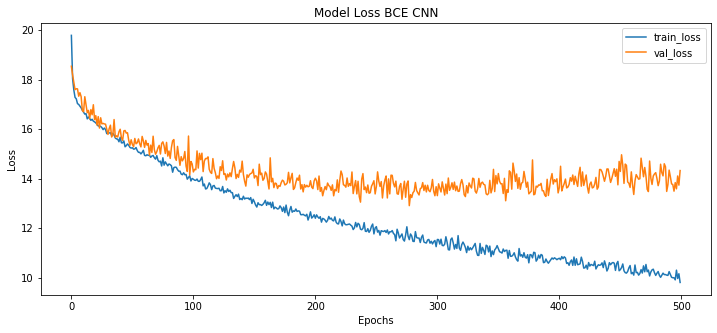

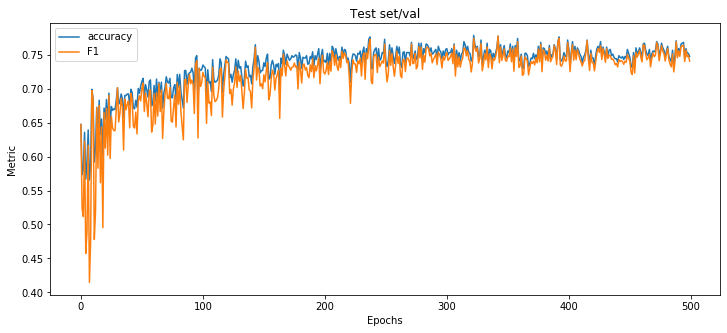

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.820392,0.838813,0.829500,0.774664,0.751128,0.775808
Confirmed,0.687403,0.658718,0.672755,0.774664,0.751128,0.775808


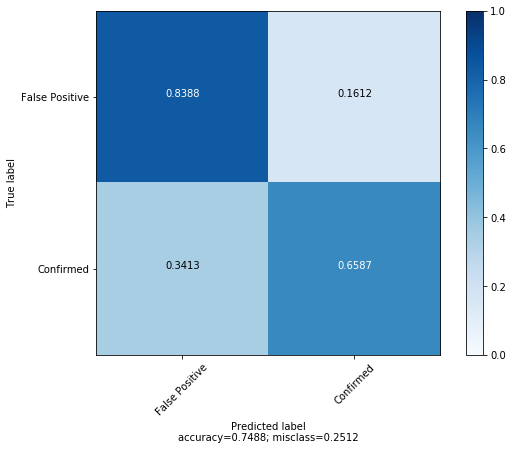

{'Precision raw': array([0.82039216, 0.6874028 ]),
 'Recall raw': array([0.83881315, 0.65871833]),
 'F1 raw': array([0.8295004 , 0.67275495]),
 'F1 weighted': 0.7746640061016871,
 'F1 macro': 0.7511276716191276,
 'F1 micro': 0.7758081334723671,
 'Confusion Matrix': array([[1046,  201],
        [ 229,  442]])}

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.5, gamma=1),optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
hist=model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  callbacks=[metrics,mcp_save])
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
   
keras.losses.binary_focal_loss_fixed = keras.losses.mse
best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

###### lr decay

In [19]:
def create_model(x_train, y_train, x_test, y_test):
    ####### PARA MEDIR F1 AL FINA LDE EPOCH ###########
    class Metrics(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.val_f1s = []

        def on_epoch_end(self, batch, logs={}):
            predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
            targ = np.squeeze(self.validation_data[1])
            f1s = f1_score(targ, predict, average='macro')
            self.val_f1s.append(f1s)
            #print(" - val_f1: %f " %(f1s))
            return
    #elejir modelo?
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    #elejir global?
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='Adam')
    
    metrics = Metrics()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',
                                  factor={{uniform(0.01,0.5)}},
                                  patience={{choice([5,10,15,20])}}, min_lr=0.001)
    result = model.fit(x_train, y_train,
                  batch_size={{choice([64, 128, 256 ,512])}},
                  epochs=200,
                  verbose=0,
                  validation_split=0.1, callbacks=[metrics, reduce_lr])

    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(metrics.val_f1s) #np.amax(result.history['val_f1']) 
    print('Best validation metric of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [35]:
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=1,
                                          trials=Trials(),
                                     notebook_name='el_mejor_76')
print(best_run)

x_train, y_train, x_val, y_val = data()

predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from scipy.stats import norm
except:
    pass

try:
    import itertools
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.metrics import mean_squared_error as mse
except:
    pass

try:
    from sklearn.utils import class_weight
except:
    pass

try:
    from astropy.io import fits
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import os, sys
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, accuracy_score
except:
    pass

try:
    from keras.regularizers import l2
except:
    pass

try:
    from keras.activations import tanh
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import *
except:
    pass

try:
    from keras.losses import catego

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                    
0.7381847826086956                                  
 10%|█         | 1/10 [06:04<54:44, 364.98s/it, best loss: -0.7381847826086956]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Best validation metric of epoch:                                               
0.7586545729402872                                                             
Best validation metric of epoch:                                               
0.7641304347826086                                                             
Best validation metric of epoch:                                               
0.7326978858911034                                                             
Best validation metric of epoch:                                               
0.7439490085520051                                                             
 50%|█████     | 5/10 [33:27<32:46, 393.36s/it, best loss: -0.7641304347826086]

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



KeyboardInterrupt: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
__________

7810/7810 [==============================] - 2s 287us/step - loss: 0.4615 - acc: 0.7238 - val_loss: 0.4766 - val_acc: 0.7120
Epoch 63/200
7810/7810 [==============================] - 2s 294us/step - loss: 0.4617 - acc: 0.7237 - val_loss: 0.4899 - val_acc: 0.6935
Epoch 64/200
7810/7810 [==============================] - 2s 287us/step - loss: 0.4623 - acc: 0.7241 - val_loss: 0.4816 - val_acc: 0.6959
Epoch 65/200
7810/7810 [==============================] - 2s 285us/step - loss: 0.4578 - acc: 0.7277 - val_loss: 0.4875 - val_acc: 0.6901
Epoch 66/200
7810/7810 [==============================] - 2s 298us/step - loss: 0.4617 - acc: 0.7215 - val_loss: 0.4832 - val_acc: 0.6855
Epoch 67/200
7810/7810 [==============================] - 2s 274us/step - loss: 0.4588 - acc: 0.7314 - val_loss: 0.4802 - val_acc: 0.7085
Epoch 68/200
7810/7810 [==============================] - 2s 273us/step - loss: 0.4607 - acc: 0.7223 - val_loss: 0.4812 - val_acc: 0.7074
Epoch 69/200
7810/7810 [=======================

7810/7810 [==============================] - 2s 301us/step - loss: 0.4233 - acc: 0.7653 - val_loss: 0.4618 - val_acc: 0.7304
Epoch 131/200
7810/7810 [==============================] - 2s 282us/step - loss: 0.4157 - acc: 0.7688 - val_loss: 0.4537 - val_acc: 0.7362
Epoch 132/200
7810/7810 [==============================] - 2s 302us/step - loss: 0.4174 - acc: 0.7679 - val_loss: 0.4557 - val_acc: 0.7362
Epoch 133/200
7810/7810 [==============================] - 2s 314us/step - loss: 0.4174 - acc: 0.7659 - val_loss: 0.4563 - val_acc: 0.7235
Epoch 134/200
7810/7810 [==============================] - 2s 305us/step - loss: 0.4231 - acc: 0.7662 - val_loss: 0.4584 - val_acc: 0.7316
Epoch 135/200
7810/7810 [==============================] - 2s 310us/step - loss: 0.4234 - acc: 0.7625 - val_loss: 0.4538 - val_acc: 0.7293
Epoch 136/200
7810/7810 [==============================] - 2s 315us/step - loss: 0.4179 - acc: 0.7656 - val_loss: 0.4527 - val_acc: 0.7281
Epoch 137/200
7810/7810 [================

7810/7810 [==============================] - 2s 306us/step - loss: 0.4008 - acc: 0.7781 - val_loss: 0.4444 - val_acc: 0.7454
Epoch 165/200
7810/7810 [==============================] - 2s 302us/step - loss: 0.4035 - acc: 0.7781 - val_loss: 0.4533 - val_acc: 0.7419
Epoch 166/200
7810/7810 [==============================] - 2s 312us/step - loss: 0.4114 - acc: 0.7684 - val_loss: 0.4417 - val_acc: 0.7454
Epoch 167/200
7810/7810 [==============================] - 3s 330us/step - loss: 0.4047 - acc: 0.7789 - val_loss: 0.4551 - val_acc: 0.7270
Epoch 168/200
7810/7810 [==============================] - 2s 298us/step - loss: 0.4201 - acc: 0.7690 - val_loss: 0.4407 - val_acc: 0.7488
Epoch 169/200
7810/7810 [==============================] - 2s 290us/step - loss: 0.4086 - acc: 0.7818 - val_loss: 0.4454 - val_acc: 0.7339
Epoch 170/200
7810/7810 [==============================] - 2s 296us/step - loss: 0.4091 - acc: 0.7713 - val_loss: 0.4449 - val_acc: 0.7546
Epoch 171/200
7810/7810 [================

7810/7810 [==============================] - 2s 309us/step - loss: 0.3884 - acc: 0.7918 - val_loss: 0.4287 - val_acc: 0.7615
Epoch 199/200
7810/7810 [==============================] - 2s 298us/step - loss: 0.3934 - acc: 0.7839 - val_loss: 0.4338 - val_acc: 0.7569
Epoch 200/200
7810/7810 [==============================] - 2s 280us/step - loss: 0.3879 - acc: 0.7863 - val_loss: 0.4392 - val_acc: 0.7477


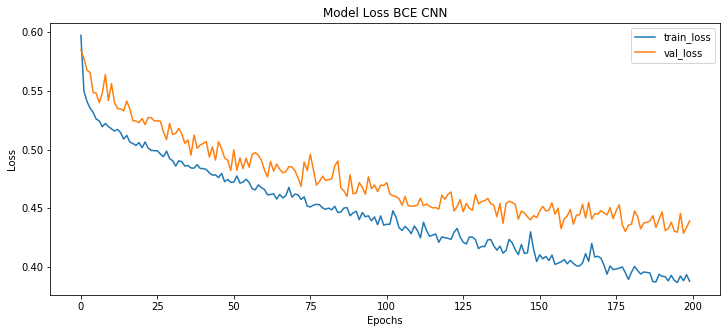

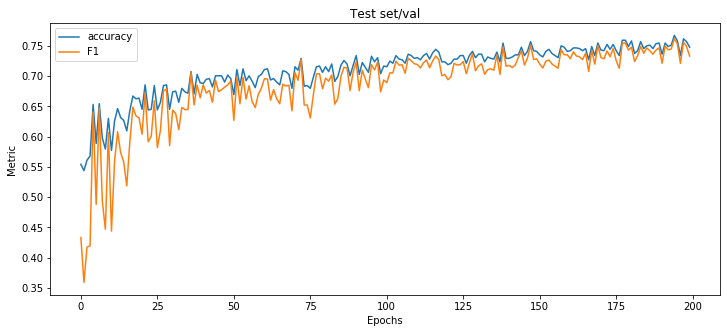

,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.853248,0.837795,0.783326,0.759947,0.785193
Confirmed,0.658718,0.682099,0.783326,0.759947,0.785193


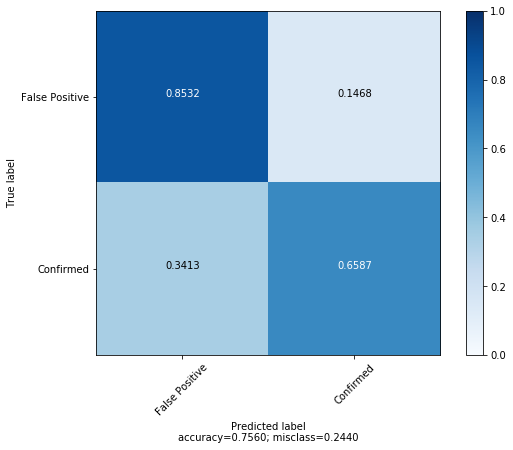

{'Recall raw': array([0.85324779, 0.65871833]),
 'F1 raw': array([0.83779528, 0.68209877]),
 'F1 weighted': 0.7833258499824587,
 'F1 macro': 0.759947020511325,
 'F1 micro': 0.7851929092805006,
 'Confusion Matrix': array([[1064,  183],
        [ 229,  442]])}

In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.27,patience=20, min_lr=0.001)
hist=model.fit(x_train, y_train, batch_size=64, epochs=200, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  callbacks=[metrics,mcp_save,reduce_lr])
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
    

best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [20]:
#Pretrained Model
#1 chillion de imports
import os
from keras.datasets import cifar100,cifar10,mnist,fashion_mnist
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import Dense, Flatten,Conv2D, MaxPooling2D,Dropout,AveragePooling2D,GlobalAveragePooling2D,Activation,ZeroPadding2D
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD,Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from PIL import Image
from time import time
import tensorflow
import keras
import keras.backend as K
from keras.backend import eval
import glob

In [21]:
#Pruebas con 128x128

model = Sequential()
model.add(Conv2D(256, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.27,patience=20, min_lr=0.001)
hist=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  callbacks=[metrics,mcp_save,reduce_lr])
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
    

best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [26]:
x_train.shape[1:]

(256, 256, 2)

In [ ]:
model = Sequential()

In [36]:
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.layers import Input
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from keras.models import Sequential
from keras.layers import Dense, Flatten,Conv2D, MaxPooling2D,Dropout,AveragePooling2D,GlobalAveragePooling2D,Activation,ZeroPadding2D

T_ResNet50 = ResNet50(include_top=False, weights=None, input_shape=x_train.shape[1:], classes=1)
model = Sequential()
model.add(T_ResNet50)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.27,patience=20, min_lr=0.001)
hist=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  callbacks=[metrics,mcp_save,reduce_lr])
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
    

best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23584576  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,586,625
Trainable params: 23,533,505
Non-trainable params: 53,120
_________________________________________________________________
Train on 7810 samples, validate on 868 samples
Epoch 1/50


TypeError: 'NoneType' object is not subscriptable

# Att Model

In [23]:
from keras.layers import Dense, Dropout,  Conv2D, Input, Lambda, Flatten, TimeDistributed
from keras.layers import Add, Reshape, MaxPooling2D, Concatenate, Embedding, RepeatVector
from keras.models import Model
from keras import backend as K

import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.engine.topology import Layer
import tensorflow as tf
from keras.callbacks import TensorBoard

def MultiHeadATT(l,d,dv,dout,v):

    v1 = Input(shape = (l, d))
    q1 = Input(shape = (l, d))
    k1 = Input(shape = (l, d))

    v2 = Dense(dv*nv, activation = "relu")(v1)
    q2 = Dense(dv*nv, activation = "relu")(q1)
    k2 = Dense(dv*nv, activation = "relu")(k1)

    v = Reshape([l, nv, dv])(v2)
    q = Reshape([l, nv, dv])(q2)
    k = Reshape([l, nv, dv])(k2)
        
    att = Lambda(lambda x: K.batch_dot(x[0],x[1] ,axes=[-1,-1]) / np.sqrt(dv),output_shape=(l, nv, nv))([q,k])# l, nv, nv
    print(att.shape)
    att = Lambda(lambda x:  K.softmax(x) , output_shape=(l, nv, nv))(att)
    print(att.shape)
    out = Lambda(lambda x: K.batch_dot(x[0], x[1],axes=[4,3]),  output_shape=(l, nv, dv))([att, v])
    print(out.shape)
    print(l,d)
    out = Reshape([l, d])(out)
    
    out = Add()([out, q1])

    out = Dense(dout, activation = "relu")(out)

    return  Model(inputs=[q1,k1,v1], outputs=out)

class NormL(Layer):
    def __init__(self, **kwargs):
        super(NormL, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.a = self.add_weight(name='kernel', 
                                      shape=(1,input_shape[-1]),
                                      initializer='ones',
                                      trainable=True)
        self.b = self.add_weight(name='kernel', 
                                      shape=(1,input_shape[-1]),
                                      initializer='zeros',
                                      trainable=True)
        super(NormL, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        eps = 0.000001
        mu = K.mean(x, keepdims=True, axis=-1)
        sigma = K.std(x, keepdims=True, axis=-1)
        ln_out = (x - mu) / (sigma + eps)
        return ln_out*self.a + self.b

    def compute_output_shape(self, input_shape):
        return input_shape
    

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
__________

In [21]:
att = MultiHeadsAttModel(l=7*7, d=9*3 , dv=3*3, dout=12, nv = 3 )




(?, 49, 9, 9)
(?, 49, 9, 9)
(?, 49, 9, 3)
49 27


(?, 36, 9, 9)
(?, 36, 9, 9)
(?, 36, 9, 3)
36 27
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 30, 30, 2)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   608         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 14, 14, 32)   0           max_pooling2d_5[0][0]            
_____________________________________________________________

Epoch 33/200
7810/7810 [==============================] - 3s 349us/step - loss: 16.7331 - acc: 0.6686 - val_loss: 17.3283 - val_acc: 0.5945
Epoch 34/200
7810/7810 [==============================] - 3s 348us/step - loss: 16.7298 - acc: 0.6672 - val_loss: 16.9938 - val_acc: 0.6233
Epoch 35/200
7810/7810 [==============================] - 3s 350us/step - loss: 16.7002 - acc: 0.6662 - val_loss: 16.7441 - val_acc: 0.6694
Epoch 36/200
7810/7810 [==============================] - 3s 349us/step - loss: 16.8102 - acc: 0.6644 - val_loss: 16.9941 - val_acc: 0.6164
Epoch 37/200
7810/7810 [==============================] - 3s 349us/step - loss: 16.6358 - acc: 0.6635 - val_loss: 17.0656 - val_acc: 0.6233
Epoch 38/200
7810/7810 [==============================] - 3s 348us/step - loss: 16.7656 - acc: 0.6720 - val_loss: 16.9228 - val_acc: 0.6187
Epoch 39/200
7810/7810 [==============================] - 3s 349us/step - loss: 16.6012 - acc: 0.6727 - val_loss: 16.7732 - val_acc: 0.6048
Epoch 40/200
7810/78

7810/7810 [==============================] - 3s 348us/step - loss: 15.2104 - acc: 0.7170 - val_loss: 16.1733 - val_acc: 0.6544
Epoch 150/200
7810/7810 [==============================] - 3s 348us/step - loss: 15.2892 - acc: 0.7106 - val_loss: 15.1173 - val_acc: 0.7051
Epoch 151/200
7810/7810 [==============================] - 3s 349us/step - loss: 15.1911 - acc: 0.7118 - val_loss: 15.1615 - val_acc: 0.7039
Epoch 152/200
7810/7810 [==============================] - 3s 350us/step - loss: 15.1816 - acc: 0.7128 - val_loss: 15.8268 - val_acc: 0.6820
Epoch 153/200
7810/7810 [==============================] - 3s 350us/step - loss: 15.1965 - acc: 0.7134 - val_loss: 15.2511 - val_acc: 0.6959
Epoch 154/200
7810/7810 [==============================] - 3s 348us/step - loss: 15.2367 - acc: 0.7146 - val_loss: 15.1743 - val_acc: 0.6924
Epoch 155/200
7810/7810 [==============================] - 3s 349us/step - loss: 15.2193 - acc: 0.7099 - val_loss: 15.2523 - val_acc: 0.6935
Epoch 156/200
7810/7810 [==

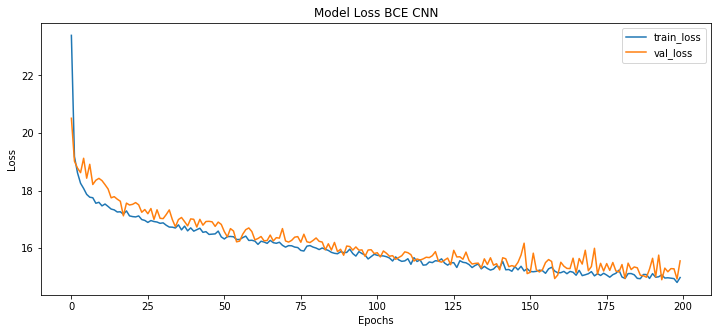

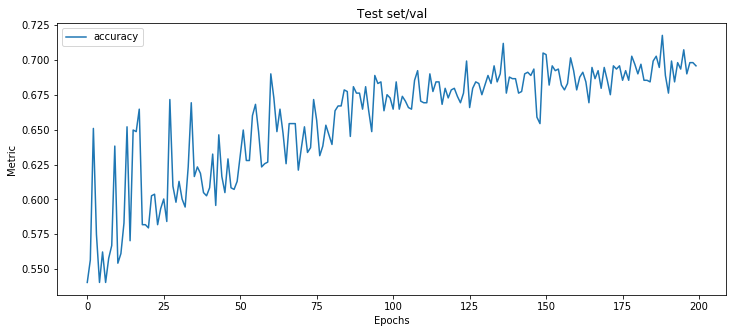

,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.784282,0.800983,0.748639,0.726173,0.746611
Confirmed,0.676602,0.651363,0.748639,0.726173,0.746611


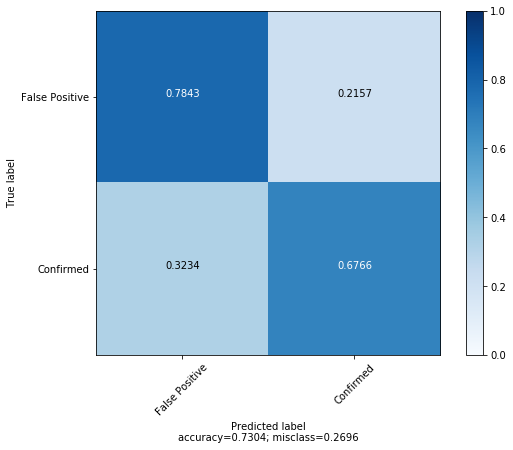

{'Recall raw': array([0.78428228, 0.67660209]),
 'F1 raw': array([0.8009828 , 0.65136298]),
 'F1 weighted': 0.7486392675890942,
 'F1 macro': 0.7261728926004392,
 'F1 micro': 0.7466110531803963,
 'Confusion Matrix': array([[978, 269],
        [217, 454]])}

In [25]:
inp = Input(shape = x_train.shape[1:])
x = Conv2D(32,(3,3),activation='relu', padding='valid')(inp)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.5)(x)
x = Conv2D(9*3,(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = Dropout(rate=0.5)(x)
x = Reshape([6*6,9*3])(x)    
att = MultiHeadsAttModel(l=6*6, d=9*3 , dv=3*3, dout=12, nv = 3 )
x = att([x,x,x])
x = Reshape([6,6,12])(x)
x = NormL()(x)
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=x)
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.5, gamma=1),optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
hist=model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  #callbacks=[metrics,mcp_save]
              )
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
#plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
   
keras.losses.binary_focal_loss_fixed = keras.losses.mse
best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [61]:
att = MultiHeadsAttModel(l=6*6, d=64*3 , dv=8*3, dout=32, nv = 8 )

(?, 36, 24, 24)
(?, 36, 24, 24)
(?, 36, 24, 8)
36 192


In [ ]:
inp = Input(shape = x_train.shape[1:])
x = Conv2D(32,(2,2),activation='relu', padding='same')(inp)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.25)(x)
x = Conv2D(64,(2,2),activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Dropout(rate=0.25)(x)
x = Conv2D(64*3,(2,2),activation='relu')(x)
x = Reshape([6*6,64*3])(x)    
att = MultiHeadsAttModel(l=6*6, d=64*3 , dv=8*3, dout=32, nv = 8 )
x = att([x,x,x])
x = Reshape([6,6,32])(x)   
x = NormL()(x)
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.5, gamma=1),optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
hist=model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  #callbacks=[metrics,mcp_save]
              )
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
#plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
   
keras.losses.binary_focal_loss_fixed = keras.losses.mse
best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [211]:
import keras
from keras_multi_head import MultiHeadAttention
l = 32
d = 128

input_query = keras.layers.Input(
    shape=(l, d),
    name='Input-Q',
)
input_key = keras.layers.Input(
    shape=(l, d),
    name='Input-K',
)
input_value = keras.layers.Input(
    shape=(l, d),
    name='Input-V',
)
att_layer = MultiHeadAttention(
    head_num=8,
    name='Multi-Head',
)([input_query, input_key, input_value])
att_model = keras.models.Model(inputs=[input_query, input_key, input_value], outputs=att_layer)
att_model.summary()

#'att = MultiHeadsAttModel(l=6*6, d=64*3 , dv=8*3, dout=32, nv = 8 )'
att_layer

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Q (InputLayer)            (None, 32, 128)      0                                            
__________________________________________________________________________________________________
Input-K (InputLayer)            (None, 32, 128)      0                                            
__________________________________________________________________________________________________
Input-V (InputLayer)            (None, 32, 128)      0                                            
__________________________________________________________________________________________________
Multi-Head (MultiHeadAttention) (None, 32, 128)      66048       Input-Q[0][0]                    
                                                                 Input-K[0][0]                    
          

<tf.Tensor 'Multi-Head_65/Relu_3:0' shape=(?, ?, 128) dtype=float32>

In [223]:
#from keras.utils import plot_model

inp = Input(shape = x_train.shape[1:])
x = Conv2D(32,(2,2),activation='relu', padding='same')(inp)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.25)(x)
x = Conv2D(64,(2,2),activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Dropout(rate=0.25)(x)
x = Conv2D(128,(2,2),activation='relu')(x)
x = Reshape([6*6,128])(x)  
#att = MultiHeadsAttModel(l=6*6, d=128 , dv=8*3, dout=32, nv = 8 )
#x = att([x,x,x])
#x = Reshape([6,6,32])(x)  
#x = NormL()(x)
#x = Flatten()(x) 
#x = Dense(256, activation='relu')(x)
#x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss=binary_focal_loss(alpha=0.5, gamma=1),optimizer='Adam',metrics=['accuracy'])

model.summary()
#plot_model(model,to_file='./model.png',show_shapes=True)
#outputs = [layer.output for layer in model.layers]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_126 (InputLayer)       (None, 30, 30, 2)         0         
_________________________________________________________________
conv2d_293 (Conv2D)          (None, 30, 30, 32)        288       
_________________________________________________________________
max_pooling2d_177 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_177 (Dropout)        (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_294 (Conv2D)          (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_178 (MaxPoolin (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_178 (Dropout)        (None, 7, 7, 64)          0         
__________

In [175]:
model.compile(loss=binary_focal_loss(alpha=0.5, gamma=1),optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
hist=model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  callbacks=[metrics,mcp_save]
              )
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
#plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
   
keras.losses.binary_focal_loss_fixed = keras.losses.mse
best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

ValueError: Error when checking target: expected model_65 to have 3 dimensions, but got array with shape (8678, 1)